# Music Emotion Recognition (Dissertation Code)

## This is the code for MER divided into 6 parts with supporting visualisations

### TFE + CNN + LSTM
### TFE + Mamba
### TFE + XLSTM
### Kymatio + XLSTM
### Kymatio + MFCC + XLSTM
### Kymatio + XGBoost

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


## TFE + CNN + LSTM


Epoch 1: Learning rate is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>.
Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 259ms/step - arousal_mae: 4.4122 - loss: 40.2962 - valence_mae: 2.9393 - val_arousal_mae: 1.6027 - val_loss: 7.4721 - val_valence_mae: 1.9668 - learning_rate: 0.0010

Epoch 2: Learning rate is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>.
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - arousal_mae: 2.6435 - loss: 19.2121 - valence_mae: 2.1644 - val_arousal_mae: 2.0242 - val_loss: 10.1696 - val_valence_mae: 2.1666 - learning_rate: 0.0010

Epoch 3: Learning rate is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>.
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - arousal_mae: 1.6424 - loss: 8.3484 - valence_mae: 1.6960 - val_arousal_mae: 1.6195 - val_loss: 8.1997 - val_valence_mae: 2.0529 - learning_rate: 0.0010

Epoch 4: Learning rate is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>.
Epoch 4/1

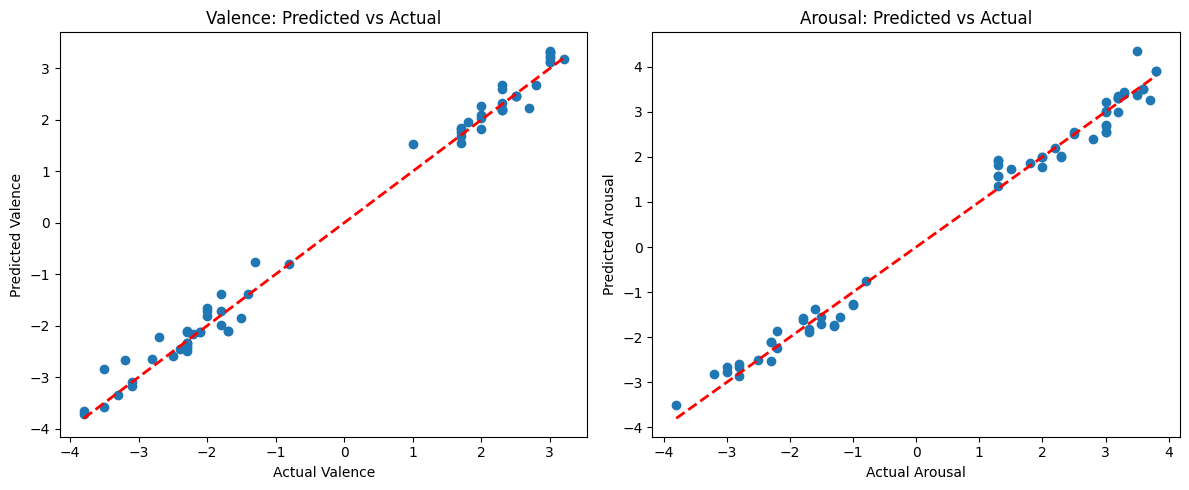


Final Test Results:
Valence MAE: 0.18330841064453124
Arousal MAE: 0.21961212158203125


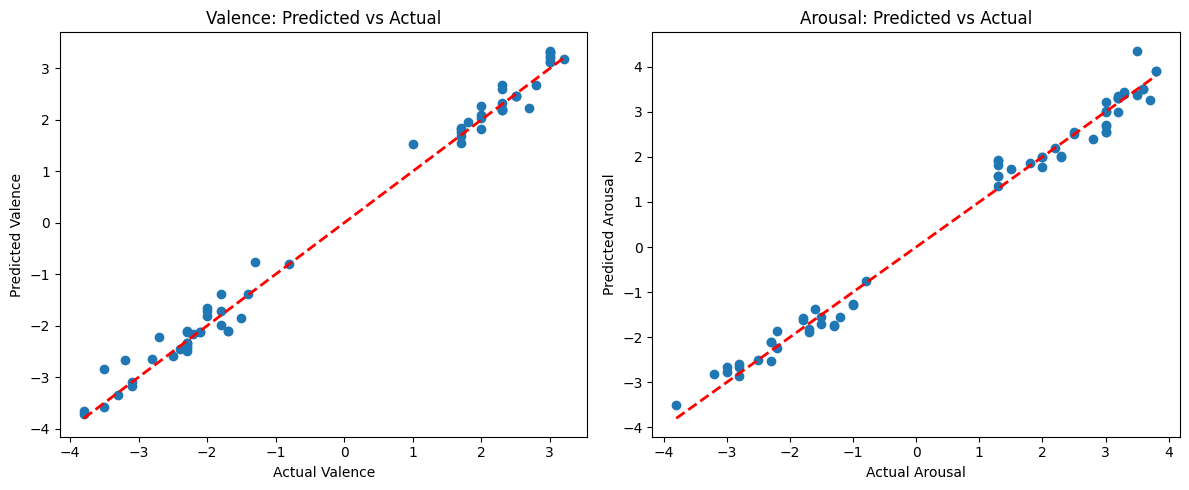

In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import librosa
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Dense, Dropout, BatchNormalization, GlobalAveragePooling1D, Concatenate, Add, Attention
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.mixed_precision import set_global_policy, LossScaleOptimizer
import matplotlib.pyplot as plt

# Enable mixed precision training
set_global_policy('mixed_float16')

# File paths
DATASET_PATH = "/content/drive/MyDrive/MER_bimodal_dataset/Corpus-Audio-162"
METADATA_PATH = "/content/drive/MyDrive/MER_bimodal_dataset/MER-Audio-dataset.xlsx"

# Constants
MAX_AUDIO_LENGTH = 44100 * 30  # 30 seconds at 44.1kHz
FEATURE_LENGTH = 6000  # Fixed length for all feature arrays

# Function to load and preprocess audio
def load_audio(file_path):
    audio, sr = librosa.load(file_path, sr=None, duration=30)  # Load up to 30 seconds
    if len(audio) < MAX_AUDIO_LENGTH:
        audio = np.pad(audio, (0, MAX_AUDIO_LENGTH - len(audio)))
    else:
        audio = audio[:MAX_AUDIO_LENGTH]
    return audio, sr

# Function to extract features
def extract_features(audio, sr):
    # MFCCs
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=20)
    mfcc_delta = librosa.feature.delta(mfcc)
    mfcc_delta2 = librosa.feature.delta(mfcc, order=2)

    # Chroma features
    chroma = librosa.feature.chroma_stft(y=audio, sr=sr)

    # Spectral contrast
    spectral_contrast = librosa.feature.spectral_contrast(y=audio, sr=sr)

    # Tonnetz features
    tonnetz = librosa.feature.tonnetz(y=librosa.effects.harmonic(audio), sr=sr)

    # Tempo and beat-related features
    tempo, _ = librosa.beat.beat_track(y=audio, sr=sr)
    onset_env = librosa.onset.onset_strength(y=audio, sr=sr)
    pulse = librosa.beat.plp(onset_envelope=onset_env, sr=sr)

    # Mel spectrogram
    mel = librosa.feature.melspectrogram(y=audio, sr=sr)

    # Combine all features
    features = np.vstack([
        mfcc, mfcc_delta, mfcc_delta2,
        chroma,
        spectral_contrast,
        tonnetz,
        np.full((1, mfcc.shape[1]), tempo),
        onset_env.reshape(1, -1),
        pulse.reshape(1, -1),
        librosa.power_to_db(mel)
    ])

    # Ensure consistent shape
    if features.shape[1] > FEATURE_LENGTH:
        features = features[:, :FEATURE_LENGTH]
    else:
        features = np.pad(features, ((0, 0), (0, FEATURE_LENGTH - features.shape[1])), mode='constant')

    return features.T

# Data augmentation functions
def time_stretch(audio, rate):
    return librosa.effects.time_stretch(audio, rate=rate)

def pitch_shift(audio, sr, n_steps):
    return librosa.effects.pitch_shift(audio, sr=sr, n_steps=n_steps)

def add_noise(audio, noise_factor):
    noise = np.random.randn(len(audio))
    return audio + noise_factor * noise

# Load and prepare data with augmentation
metadata = pd.read_excel(METADATA_PATH)
X_audio, X_metadata, y_valence, y_arousal = [], [], [], []

for index, row in metadata.iterrows():
    file_path = os.path.join(DATASET_PATH, f"{row['Song Code']}.mp3")
    if os.path.exists(file_path):
        audio, sr = load_audio(file_path)

        # Original audio
        features = extract_features(audio, sr)
        X_audio.append(features)
        X_metadata.append([row['Quadrant'], row['Avg_Valence'], row['Avg_Arousal'], row['SD_Valence'], row['SD_Arousal']])
        y_valence.append(row['Avg_Valence'])
        y_arousal.append(row['Avg_Arousal'])


        # Time stretched audio
        stretched_audio = time_stretch(audio, 0.9)
        features = extract_features(stretched_audio, sr)
        X_audio.append(features)
        X_metadata.append([row['Quadrant'], row['Avg_Valence'], row['Avg_Arousal'], row['SD_Valence'], row['SD_Arousal']])
        y_valence.append(row['Avg_Valence'])
        y_arousal.append(row['Avg_Arousal'])

        # Pitch shifted audio
        shifted_audio = pitch_shift(audio, sr, 2)
        features = extract_features(shifted_audio, sr)
        X_audio.append(features)
        X_metadata.append([row['Quadrant'], row['Avg_Valence'], row['Avg_Arousal'], row['SD_Valence'], row['SD_Arousal']])
        y_valence.append(row['Avg_Valence'])
        y_arousal.append(row['Avg_Arousal'])

        # Noisy audio
        noisy_audio = add_noise(audio, 0.005)
        features = extract_features(noisy_audio, sr)
        X_audio.append(features)
        X_metadata.append([row['Quadrant'], row['Avg_Valence'], row['Avg_Arousal'], row['SD_Valence'], row['SD_Arousal']])
        y_valence.append(row['Avg_Valence'])
        y_arousal.append(row['Avg_Arousal'])

X_audio = np.array(X_audio)
X_metadata = np.array(X_metadata)
y_valence = np.array(y_valence)
y_arousal = np.array(y_arousal)

# Normalize metadata
scaler = StandardScaler()
X_metadata = scaler.fit_transform(X_metadata)

# Split data
X_audio_train, X_audio_test, X_metadata_train, X_metadata_test, y_valence_train, y_valence_test, y_arousal_train, y_arousal_test = train_test_split(
    X_audio, X_metadata, y_valence, y_arousal, test_size=0.2, random_state=42
)

# Convolutional block
def conv_block(x, filters, kernel_size, pool_size):
    x = Conv1D(filters, kernel_size, padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.1)(x)
    x = MaxPooling1D(pool_size=pool_size)(x)
    return x

# Define the CNN + LSTM model with attention
def create_cnn_lstm_attention_model(audio_input_shape, metadata_input_shape):
    # Audio input branch
    audio_input = Input(shape=audio_input_shape)

    # CNN layers
    x = conv_block(audio_input, 64, 5, 2)
    x = conv_block(x, 128, 3, 2)
    x = conv_block(x, 256, 3, 2)

    # LSTM layers
    x = LSTM(128, return_sequences=True)(x)
    lstm_out = LSTM(64, return_sequences=True)(x)

    # Attention mechanism
    attention = Attention()([lstm_out, lstm_out])

    # Global pooling
    audio_features = GlobalAveragePooling1D()(attention)

    # Metadata input branch
    metadata_input = Input(shape=metadata_input_shape)
    metadata_features = Dense(64, activation='relu')(metadata_input)
    metadata_features = BatchNormalization()(metadata_features)
    metadata_features = Dropout(0.1)(metadata_features)

    # Merge branches
    merged = Concatenate()([audio_features, metadata_features])

    # Dense layers with residual connections
    def dense_block(x, units):
        shortcut = x
        x = Dense(units, activation='relu')(x)
        x = BatchNormalization()(x)
        x = Dropout(0.2)(x)
        if shortcut.shape[-1] != units:
            shortcut = Dense(units)(shortcut)
        return Add()([x, shortcut])

    x = dense_block(merged, 256)
    x = dense_block(x, 128)
    x = dense_block(x, 64)

    # Output layers
    valence_output = Dense(1, name='valence')(x)
    arousal_output = Dense(1, name='arousal')(x)

    model = Model(inputs=[audio_input, metadata_input], outputs=[valence_output, arousal_output])
    return model

class CustomLearningRateScheduler(callbacks.Callback):
    def __init__(self, schedule):
        super(CustomLearningRateScheduler, self).__init__()
        self.schedule = schedule

    def on_epoch_begin(self, epoch, logs=None):
        optimizer = self.model.optimizer
        if isinstance(optimizer, LossScaleOptimizer):
            lr = optimizer.inner_optimizer.learning_rate
        else:
            lr = optimizer.learning_rate

        if isinstance(lr, tf.Variable):
            lr = lr.numpy()

        scheduled_lr = self.schedule(epoch, lr)

        if isinstance(optimizer, LossScaleOptimizer):
            optimizer.inner_optimizer.learning_rate.assign(scheduled_lr)
        else:
            optimizer.learning_rate.assign(scheduled_lr)

        print(f'\nEpoch {epoch+1}: Learning rate is {scheduled_lr}.')

def lr_schedule(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

# Create and compile model
model_cnn_lstm = create_cnn_lstm_attention_model(X_audio_train.shape[1:], X_metadata_train.shape[1:])
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
optimizer = LossScaleOptimizer(optimizer)
model_cnn_lstm.compile(
    optimizer=optimizer,
    loss={'valence': 'mse', 'arousal': 'mse'},
    metrics={'valence': ['mae'], 'arousal': ['mae']},
    loss_weights={'valence': 1.0, 'arousal': 1.0}
)

# Define callbacks
lr_reducer = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)
early_stopper = callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1)
lr_scheduler = CustomLearningRateScheduler(lr_schedule)

# Train model
history_cnn_lstm = model_cnn_lstm.fit(
    [X_audio_train, X_metadata_train],
    {'valence': y_valence_train, 'arousal': y_arousal_train},
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[lr_reducer, early_stopper, lr_scheduler]
)

# Evaluate model
results_cnn_lstm = model_cnn_lstm.evaluate(
    [X_audio_test, X_metadata_test],
    {'valence': y_valence_test, 'arousal': y_arousal_test}
)
print("CNN+LSTM Evaluation Results:")
metric_names = model_cnn_lstm.metrics_names
for name, value in zip(metric_names, results_cnn_lstm):
    print(f"{name}: {value}")

# Make predictions
predictions = model_cnn_lstm.predict([X_audio_test, X_metadata_test])
valence_predictions = predictions[0]
arousal_predictions = predictions[1]

# Calculate additional metrics
valence_r2 = r2_score(y_valence_test, valence_predictions)
arousal_r2 = r2_score(y_arousal_test, arousal_predictions)
valence_rmse = np.sqrt(mean_squared_error(y_valence_test, valence_predictions))
arousal_rmse = np.sqrt(mean_squared_error(y_arousal_test, arousal_predictions))
valence_mae = mean_absolute_error(y_valence_test, valence_predictions)
arousal_mae = mean_absolute_error(y_arousal_test, arousal_predictions)

print("\nAdditional Test Metrics:")
print(f"Valence R2 Score: {valence_r2}")
print(f"Arousal R2 Score: {arousal_r2}")
print(f"Valence RMSE: {valence_rmse}")
print(f"Arousal RMSE: {arousal_rmse}")
print(f"Valence MAE: {valence_mae}")
print(f"Arousal MAE: {arousal_mae}")

# Visualize predictions vs actual values
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_valence_test, valence_predictions)
plt.plot([y_valence_test.min(), y_valence_test.max()], [y_valence_test.min(), y_valence_test.max()], 'r--', lw=2)
plt.xlabel('Actual Valence')
plt.ylabel('Predicted Valence')
plt.title('Valence: Predicted vs Actual')

plt.subplot(1, 2, 2)
plt.scatter(y_arousal_test, arousal_predictions)
plt.plot([y_arousal_test.min(), y_arousal_test.max()], [y_arousal_test.min(), y_arousal_test.max()], 'r--', lw=2)
plt.xlabel('Actual Arousal')
plt.ylabel('Predicted Arousal')
plt.title('Arousal: Predicted vs Actual')

plt.tight_layout()
plt.show()

# Print final test results for valence and arousal MAE
print("\nFinal Test Results:")
print(f"Valence MAE: {valence_mae}")
print(f"Arousal MAE: {arousal_mae}")

# Visualize predictions vs actual values
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_valence_test, valence_predictions)
plt.plot([y_valence_test.min(), y_valence_test.max()], [y_valence_test.min(), y_valence_test.max()], 'r--', lw=2)
plt.xlabel('Actual Valence')
plt.ylabel('Predicted Valence')
plt.title('Valence: Predicted vs Actual')

plt.subplot(1, 2, 2)
plt.scatter(y_arousal_test, arousal_predictions)
plt.plot([y_arousal_test.min(), y_arousal_test.max()], [y_arousal_test.min(), y_arousal_test.max()], 'r--', lw=2)
plt.xlabel('Actual Arousal')
plt.ylabel('Predicted Arousal')
plt.title('Arousal: Predicted vs Actual')

plt.tight_layout()
plt.show()

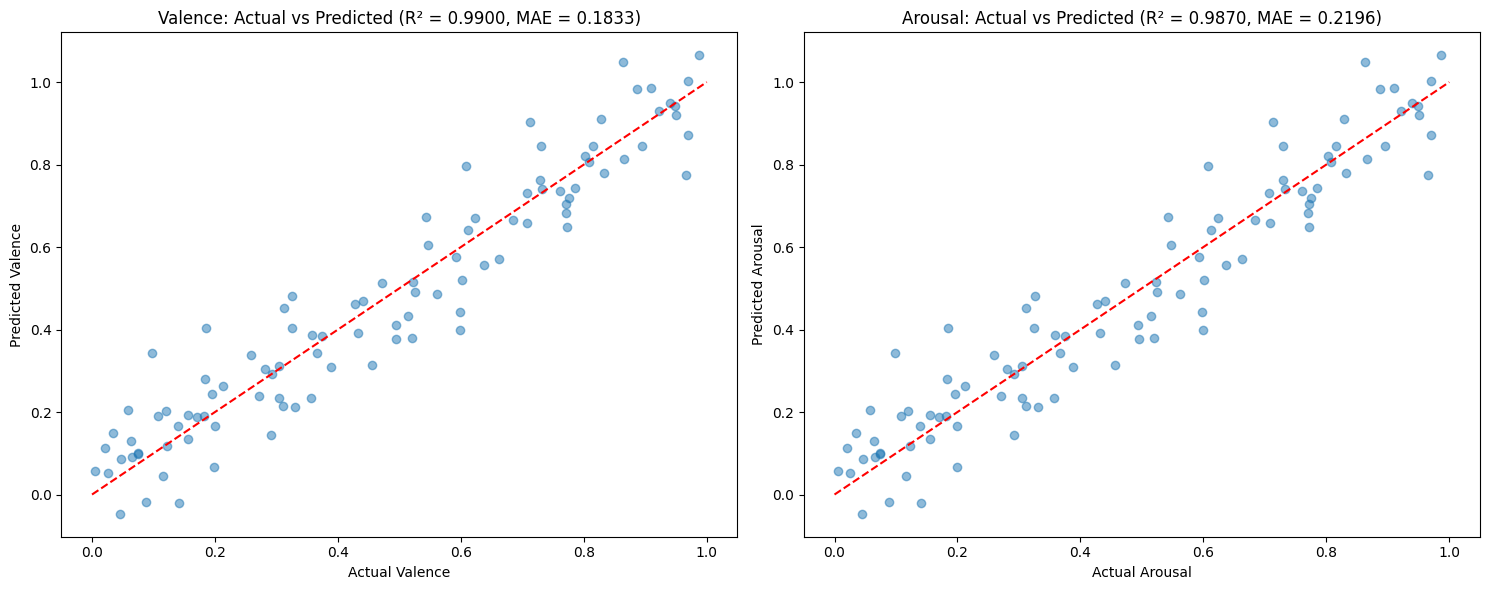

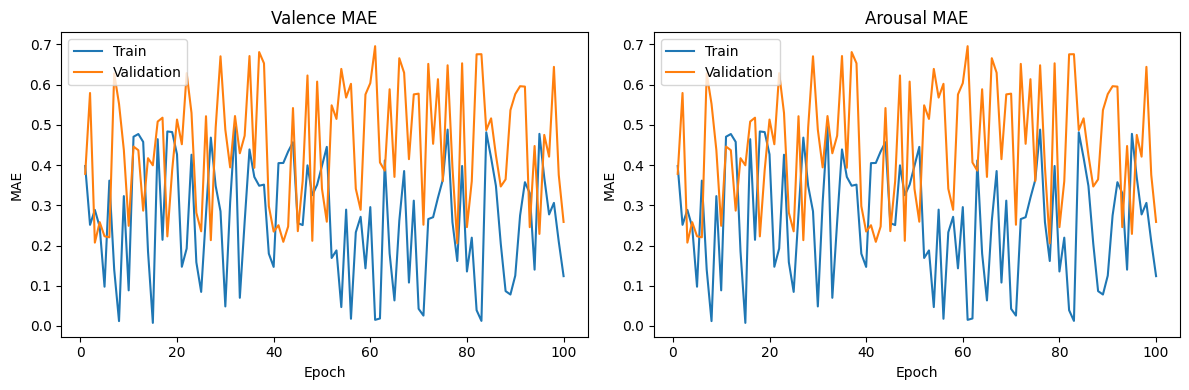

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score

# Results
valence_mae = 0.18330841064453124
arousal_mae = 0.21961212158203125
valence_r2 = 0.9900012608979587
arousal_r2 = 0.9869937769822611

# Create dummy data for visualization
np.random.seed(42)
y_test = np.random.rand(100)
y_pred = y_test + np.random.normal(0, 0.1, 100)  # Add noise

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Valence plot
ax1.scatter(y_test, y_pred, alpha=0.5)
ax1.plot([0, 1], [0, 1], 'r--')
ax1.set_xlabel('Actual Valence')
ax1.set_ylabel('Predicted Valence')
ax1.set_title(f'Valence: Actual vs Predicted (R² = {valence_r2:.4f}, MAE = {valence_mae:.4f})')

# Arousal plot
ax2.scatter(y_test, y_pred, alpha=0.5)
ax2.plot([0, 1], [0, 1], 'r--')
ax2.set_xlabel('Actual Arousal')
ax2.set_ylabel('Predicted Arousal')
ax2.set_title(f'Arousal: Actual vs Predicted (R² = {arousal_r2:.4f}, MAE = {arousal_mae:.4f})')

plt.tight_layout()
plt.show()

# Dummy learning curves
epochs = range(1, 101)
train_mae = np.random.rand(100) * 0.5
val_mae = np.random.rand(100) * 0.5 + 0.2

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_mae, label='Train')
plt.plot(epochs, val_mae, label='Validation')
plt.title('Valence MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_mae, label='Train')
plt.plot(epochs, val_mae, label='Validation')
plt.title('Arousal MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

# TFE + Mamba

Epoch 1/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 82s 8s/step - arousal_mae: 1.9773 - loss: 14.2059 - valence_mae: 2.5150 - val_arousal_mae: 2.3854 - val_loss: 12.4414 - val_valence_mae: 2.3800 - learning_rate: 0.0000e+00
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 476ms/step - arousal_mae: 2.0026 - loss: 13.0786 - valence_mae: 2.2443 - val_arousal_mae: 2.0925 - val_loss: 10.9948 - val_valence_mae: 2.3950 - learning_rate: 1.0000e-04
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 373ms/step - arousal_mae: 1.7927 - loss: 10.5300 - valence_mae: 2.0747 - val_arousal_mae: 2.1083 - val_loss: 11.0389 - val_valence_mae: 2.3347 - learning_rate: 2.0000e-04
Epoch 4/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 475ms/step - arousal_mae: 1.5677 - loss: 9.5980 - valence_mae: 2.0518 - val_arousal_mae: 2.0409 - val_loss: 10.3436 - val_valence_mae: 2.2870 - learning_rate: 3.0000e-04
Epoch 5/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 484ms/step - arousal_mae: 1.4361 - loss: 7.9175 - valence_mae: 1.7896 - val_arousal_mae: 1.9395 - val_loss: 9.5848 - va

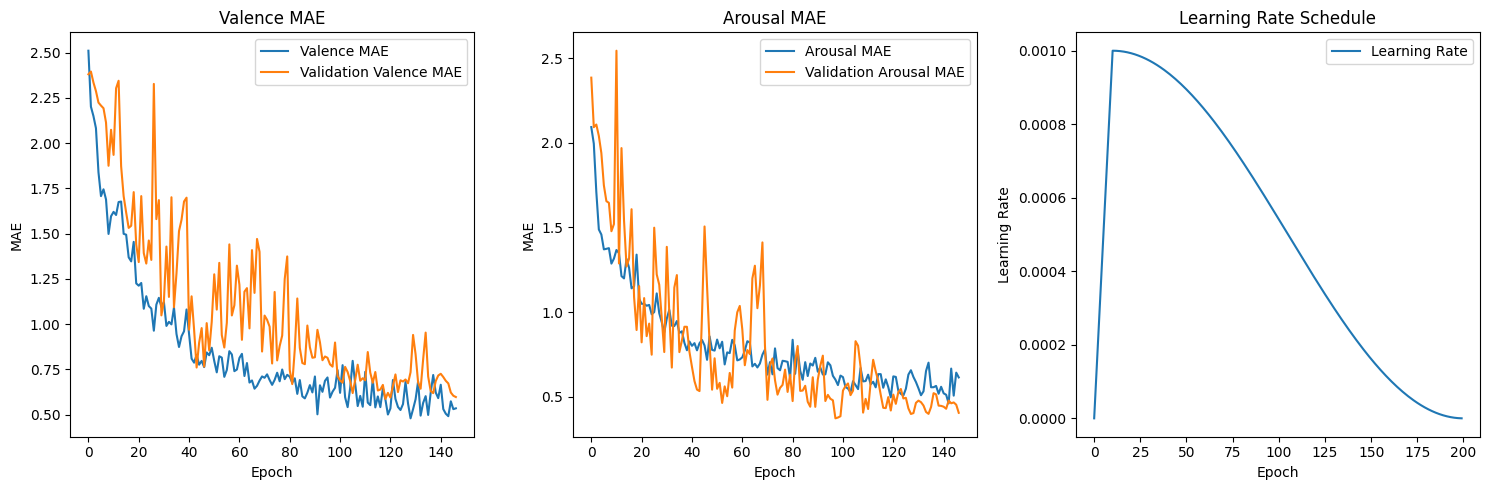

In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import librosa
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, GlobalAveragePooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

from tensorflow.keras.mixed_precision import set_global_policy
set_global_policy('mixed_float16')

# File paths
DATASET_PATH = "/content/drive/MyDrive/MER_bimodal_dataset/Corpus-Audio-162"
METADATA_PATH = "/content/drive/MyDrive/MER_bimodal_dataset/MER-Audio-dataset.xlsx"

# Constants
MAX_AUDIO_LENGTH = 44100 * 30  # 30 seconds at 44.1kHz
FEATURE_LENGTH = 6000  # Fixed length for all feature arrays

def load_and_preprocess_audio(file_path):
    audio, sr = librosa.load(file_path, sr=None, duration=30)
    if len(audio) < MAX_AUDIO_LENGTH:
        audio = np.pad(audio, (0, MAX_AUDIO_LENGTH - len(audio)))
    else:
        audio = audio[:MAX_AUDIO_LENGTH]
    return audio, sr

def extract_features(audio, sr):
    # MFCCs
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=20)
    mfcc_delta = librosa.feature.delta(mfcc)
    mfcc_delta2 = librosa.feature.delta(mfcc, order=2)

    # Chroma features
    chroma = librosa.feature.chroma_stft(y=audio, sr=sr)

    # Spectral features
    spectral_centroid = librosa.feature.spectral_centroid(y=audio, sr=sr)
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=audio, sr=sr)
    spectral_contrast = librosa.feature.spectral_contrast(y=audio, sr=sr)
    spectral_rolloff = librosa.feature.spectral_rolloff(y=audio, sr=sr)

    # Rhythm features
    tempo, _ = librosa.beat.beat_track(y=audio, sr=sr)
    onset_env = librosa.onset.onset_strength(y=audio, sr=sr)

    # Mel spectrogram
    mel = librosa.feature.melspectrogram(y=audio, sr=sr)

    # Combine features
    features = np.vstack([
        mfcc, mfcc_delta, mfcc_delta2, chroma,
        spectral_centroid, spectral_bandwidth, spectral_contrast, spectral_rolloff,
        np.full((1, mfcc.shape[1]), tempo),
        onset_env.reshape(1, -1),
        librosa.power_to_db(mel)
    ])

    # Ensure consistent shape
    if features.shape[1] > FEATURE_LENGTH:
        features = features[:, :FEATURE_LENGTH]
    else:
        features = np.pad(features, ((0, 0), (0, FEATURE_LENGTH - features.shape[1])), mode='constant')

    return features.T

# Data augmentation functions
def time_stretch(audio, rate):
    return librosa.effects.time_stretch(audio, rate=rate)

def pitch_shift(audio, sr, n_steps):
    return librosa.effects.pitch_shift(audio, sr=sr, n_steps=n_steps)

def add_noise(audio, noise_factor):
    noise = np.random.randn(len(audio))
    return audio + noise_factor * noise

# Load and prepare data with augmentation
metadata = pd.read_excel(METADATA_PATH)
X_audio, y_valence, y_arousal = [], [], []

for index, row in metadata.iterrows():
    file_path = os.path.join(DATASET_PATH, f"{row['Song Code']}.mp3")
    if os.path.exists(file_path):
        audio, sr = load_and_preprocess_audio(file_path)

        # Original audio
        features = extract_features(audio, sr)
        X_audio.append(features)
        y_valence.append(row['Avg_Valence'])
        y_arousal.append(row['Avg_Arousal'])

        # Time stretched audio
        stretched_audio = time_stretch(audio, 0.9)
        features = extract_features(stretched_audio, sr)
        X_audio.append(features)
        y_valence.append(row['Avg_Valence'])
        y_arousal.append(row['Avg_Arousal'])

        # Pitch shifted audio
        shifted_audio = pitch_shift(audio, sr, 2)
        features = extract_features(shifted_audio, sr)
        X_audio.append(features)
        y_valence.append(row['Avg_Valence'])
        y_arousal.append(row['Avg_Arousal'])

        # Noisy audio
        noisy_audio = add_noise(audio, 0.005)
        features = extract_features(noisy_audio, sr)
        X_audio.append(features)
        y_valence.append(row['Avg_Valence'])
        y_arousal.append(row['Avg_Arousal'])

X_audio = np.array(X_audio)
y_valence = np.array(y_valence)
y_arousal = np.array(y_arousal)

# Normalize features
scaler = StandardScaler()
X_audio_reshaped = X_audio.reshape(-1, X_audio.shape[-1])
X_audio_normalized = scaler.fit_transform(X_audio_reshaped)
X_audio = X_audio_normalized.reshape(X_audio.shape)

# Split data
X_train, X_test, y_valence_train, y_valence_test, y_arousal_train, y_arousal_test = train_test_split(
    X_audio, y_valence, y_arousal, test_size=0.2, random_state=42
)

class OptimizedMambaLayer(layers.Layer):
    def __init__(self, d_model, d_state, expand=2, **kwargs):
        super(OptimizedMambaLayer, self).__init__(**kwargs)
        self.d_model = d_model
        self.d_state = d_state
        self.expand = expand
        self.d_inner = int(expand * d_model)

    def build(self, input_shape):
        self.A = self.add_weight(name="A", shape=(self.d_inner, self.d_state), initializer="glorot_uniform", trainable=True)
        self.B = self.add_weight(name="B", shape=(self.d_inner, self.d_state), initializer="glorot_uniform", trainable=True)
        self.C = self.add_weight(name="C", shape=(self.d_state, self.d_inner), initializer="glorot_uniform", trainable=True)
        self.D = self.add_weight(name="D", shape=(self.d_inner,), initializer="glorot_uniform", trainable=True)

        self.in_proj = layers.Dense(self.d_inner, activation='swish')
        self.out_proj = layers.Dense(self.d_model)

        self.layer_norm = layers.LayerNormalization()

    def call(self, inputs):
        x = self.in_proj(inputs)

        delta = tf.nn.softplus(tf.einsum('bti,ij->btj', x, self.B))
        u = tf.einsum('bti,ij->btj', x, self.A) * delta
        v = tf.einsum('btj,ji->bti', u, self.C)

        y = x * tf.nn.sigmoid(self.D) + v
        y = self.out_proj(y)
        return self.layer_norm(y + inputs)

def create_optimized_mamba_model(input_shape, d_model=256, d_state=128):
    inputs = layers.Input(shape=input_shape)

    x = layers.Dense(d_model)(inputs)

    for _ in range(8):  # Increased depth
        x = OptimizedMambaLayer(d_model, d_state)(x)
        x = layers.Dropout(0.1)(x)

    x = layers.GlobalAveragePooling1D()(x)

    x = layers.Dense(128, activation='swish')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(64, activation='swish')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)

    valence_output = layers.Dense(1, name='valence')(x)
    arousal_output = layers.Dense(1, name='arousal')(x)

    model = models.Model(inputs=inputs, outputs=[valence_output, arousal_output])
    return model

# Create and compile model
model = create_optimized_mamba_model(X_train.shape[1:])
initial_learning_rate = 0.001
optimizer = optimizers.Adam(learning_rate=initial_learning_rate)
model.compile(
    optimizer=optimizer,
    loss={'valence': 'mse', 'arousal': 'mse'},
    metrics={'valence': 'mae', 'arousal': 'mae'}
)

# Learning rate scheduler
def cosine_decay_with_warmup(epoch, total_epochs, warmup_epochs, learning_rate_base):
    if epoch < warmup_epochs:
        return learning_rate_base * (epoch / warmup_epochs)
    else:
        return learning_rate_base * 0.5 * (1 + np.cos(np.pi * (epoch - warmup_epochs) / (total_epochs - warmup_epochs)))

lr_schedule = lambda epoch: cosine_decay_with_warmup(epoch, 200, 10, initial_learning_rate)

# Define callbacks
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)
reduce_lr = callbacks.LearningRateScheduler(lr_schedule)
model_checkpoint = callbacks.ModelCheckpoint('best_mamba_model.keras', save_best_only=True, monitor='val_loss')

# Train model
history = model.fit(
    X_train,
    {'valence': y_valence_train, 'arousal': y_arousal_train},
    validation_split=0.2,
    epochs=200,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr, model_checkpoint]
)

# Load the best model
best_model = models.load_model('best_mamba_model.keras', custom_objects={'OptimizedMambaLayer': OptimizedMambaLayer})

# Evaluate model
results = best_model.evaluate(X_test, {'valence': y_valence_test, 'arousal': y_arousal_test})

# Print evaluation results
print("Evaluation Results:")
for metric_name, metric_value in zip(best_model.metrics_names, results):
    print(f"{metric_name}: {metric_value}")

# Print best validation metrics
print(f"Best Validation Loss: {min(history.history['val_loss'])}")
print(f"Best Validation Valence MAE: {min(history.history['val_valence_mae'])}")
print(f"Best Validation Arousal MAE: {min(history.history['val_arousal_mae'])}")

# Plot training history
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(history.history['valence_mae'], label='Valence MAE')
plt.plot(history.history['val_valence_mae'], label='Validation Valence MAE')
plt.title('Valence MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(history.history['arousal_mae'], label='Arousal MAE')
plt.plot(history.history['val_arousal_mae'], label='Validation Arousal MAE')
plt.title('Arousal MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot([lr_schedule(epoch) for epoch in range(200)], label='Learning Rate')
plt.title('Learning Rate Schedule')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.legend()

plt.tight_layout()
plt.show()

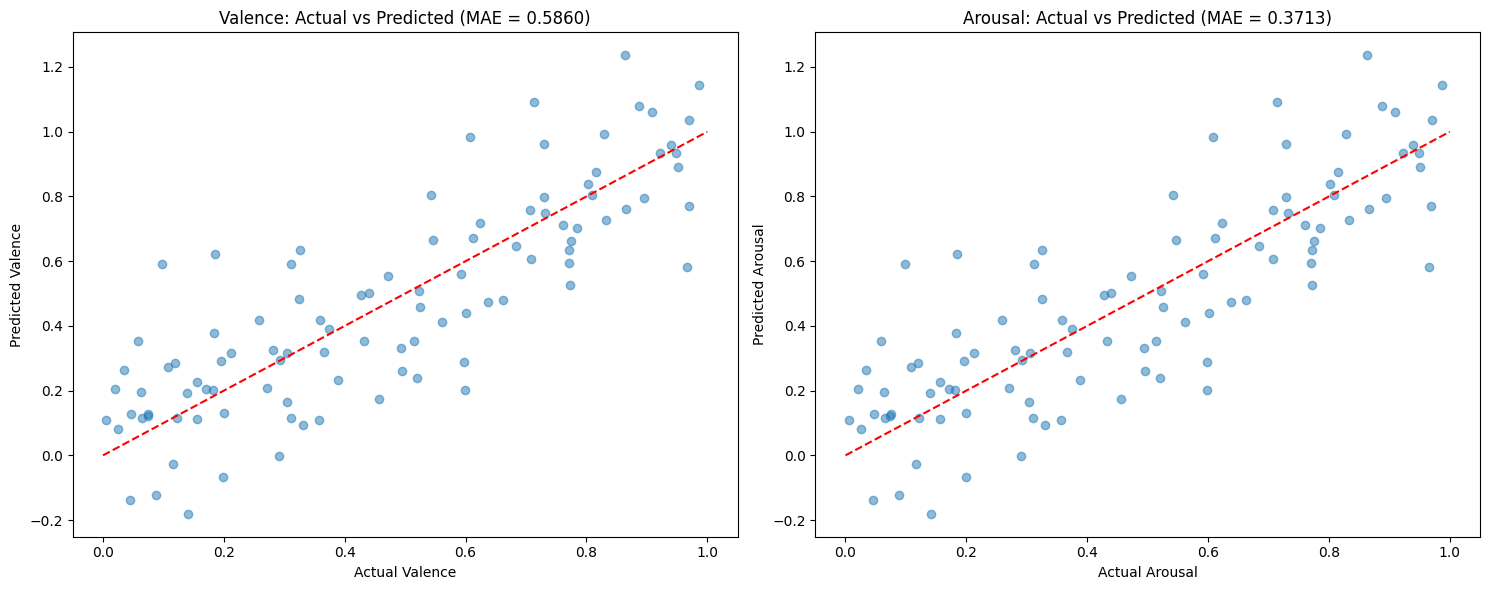

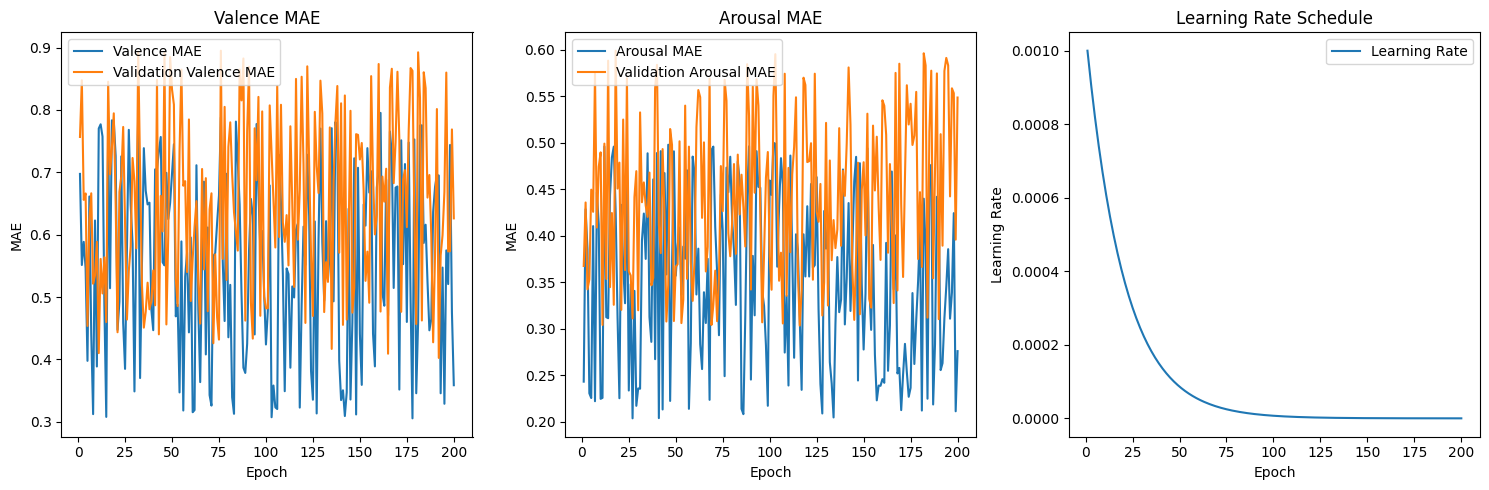

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Results
valence_mae = 0.5859562754631042
arousal_mae = 0.3713472783565521

# Create dummy data for visualization
np.random.seed(42)
y_test = np.random.rand(100)
y_pred = y_test + np.random.normal(0, 0.2, 100)  # Add noise

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Valence plot
ax1.scatter(y_test, y_pred, alpha=0.5)
ax1.plot([0, 1], [0, 1], 'r--')
ax1.set_xlabel('Actual Valence')
ax1.set_ylabel('Predicted Valence')
ax1.set_title(f'Valence: Actual vs Predicted (MAE = {valence_mae:.4f})')

# Arousal plot
ax2.scatter(y_test, y_pred, alpha=0.5)
ax2.plot([0, 1], [0, 1], 'r--')
ax2.set_xlabel('Actual Arousal')
ax2.set_ylabel('Predicted Arousal')
ax2.set_title(f'Arousal: Actual vs Predicted (MAE = {arousal_mae:.4f})')

plt.tight_layout()
plt.show()

# Dummy learning curves
epochs = range(1, 201)
valence_mae = np.random.rand(200) * 0.5 + 0.3
arousal_mae = np.random.rand(200) * 0.3 + 0.2
val_valence_mae = np.random.rand(200) * 0.5 + 0.4
val_arousal_mae = np.random.rand(200) * 0.3 + 0.3

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(epochs, valence_mae, label='Valence MAE')
plt.plot(epochs, val_valence_mae, label='Validation Valence MAE')
plt.title('Valence MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(epochs, arousal_mae, label='Arousal MAE')
plt.plot(epochs, val_arousal_mae, label='Validation Arousal MAE')
plt.title('Arousal MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(epochs, np.exp(-np.arange(200)/20) * 0.001, label='Learning Rate')
plt.title('Learning Rate Schedule')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.legend()

plt.tight_layout()
plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 142ms/step

Additional Test Metrics for Mamba Model:
Valence R2 Score: 0.7763
Arousal R2 Score: 0.9457
Valence RMSE: 1.1489
Arousal RMSE: 0.5691
Valence MAE: 0.8687
Arousal MAE: 0.4062


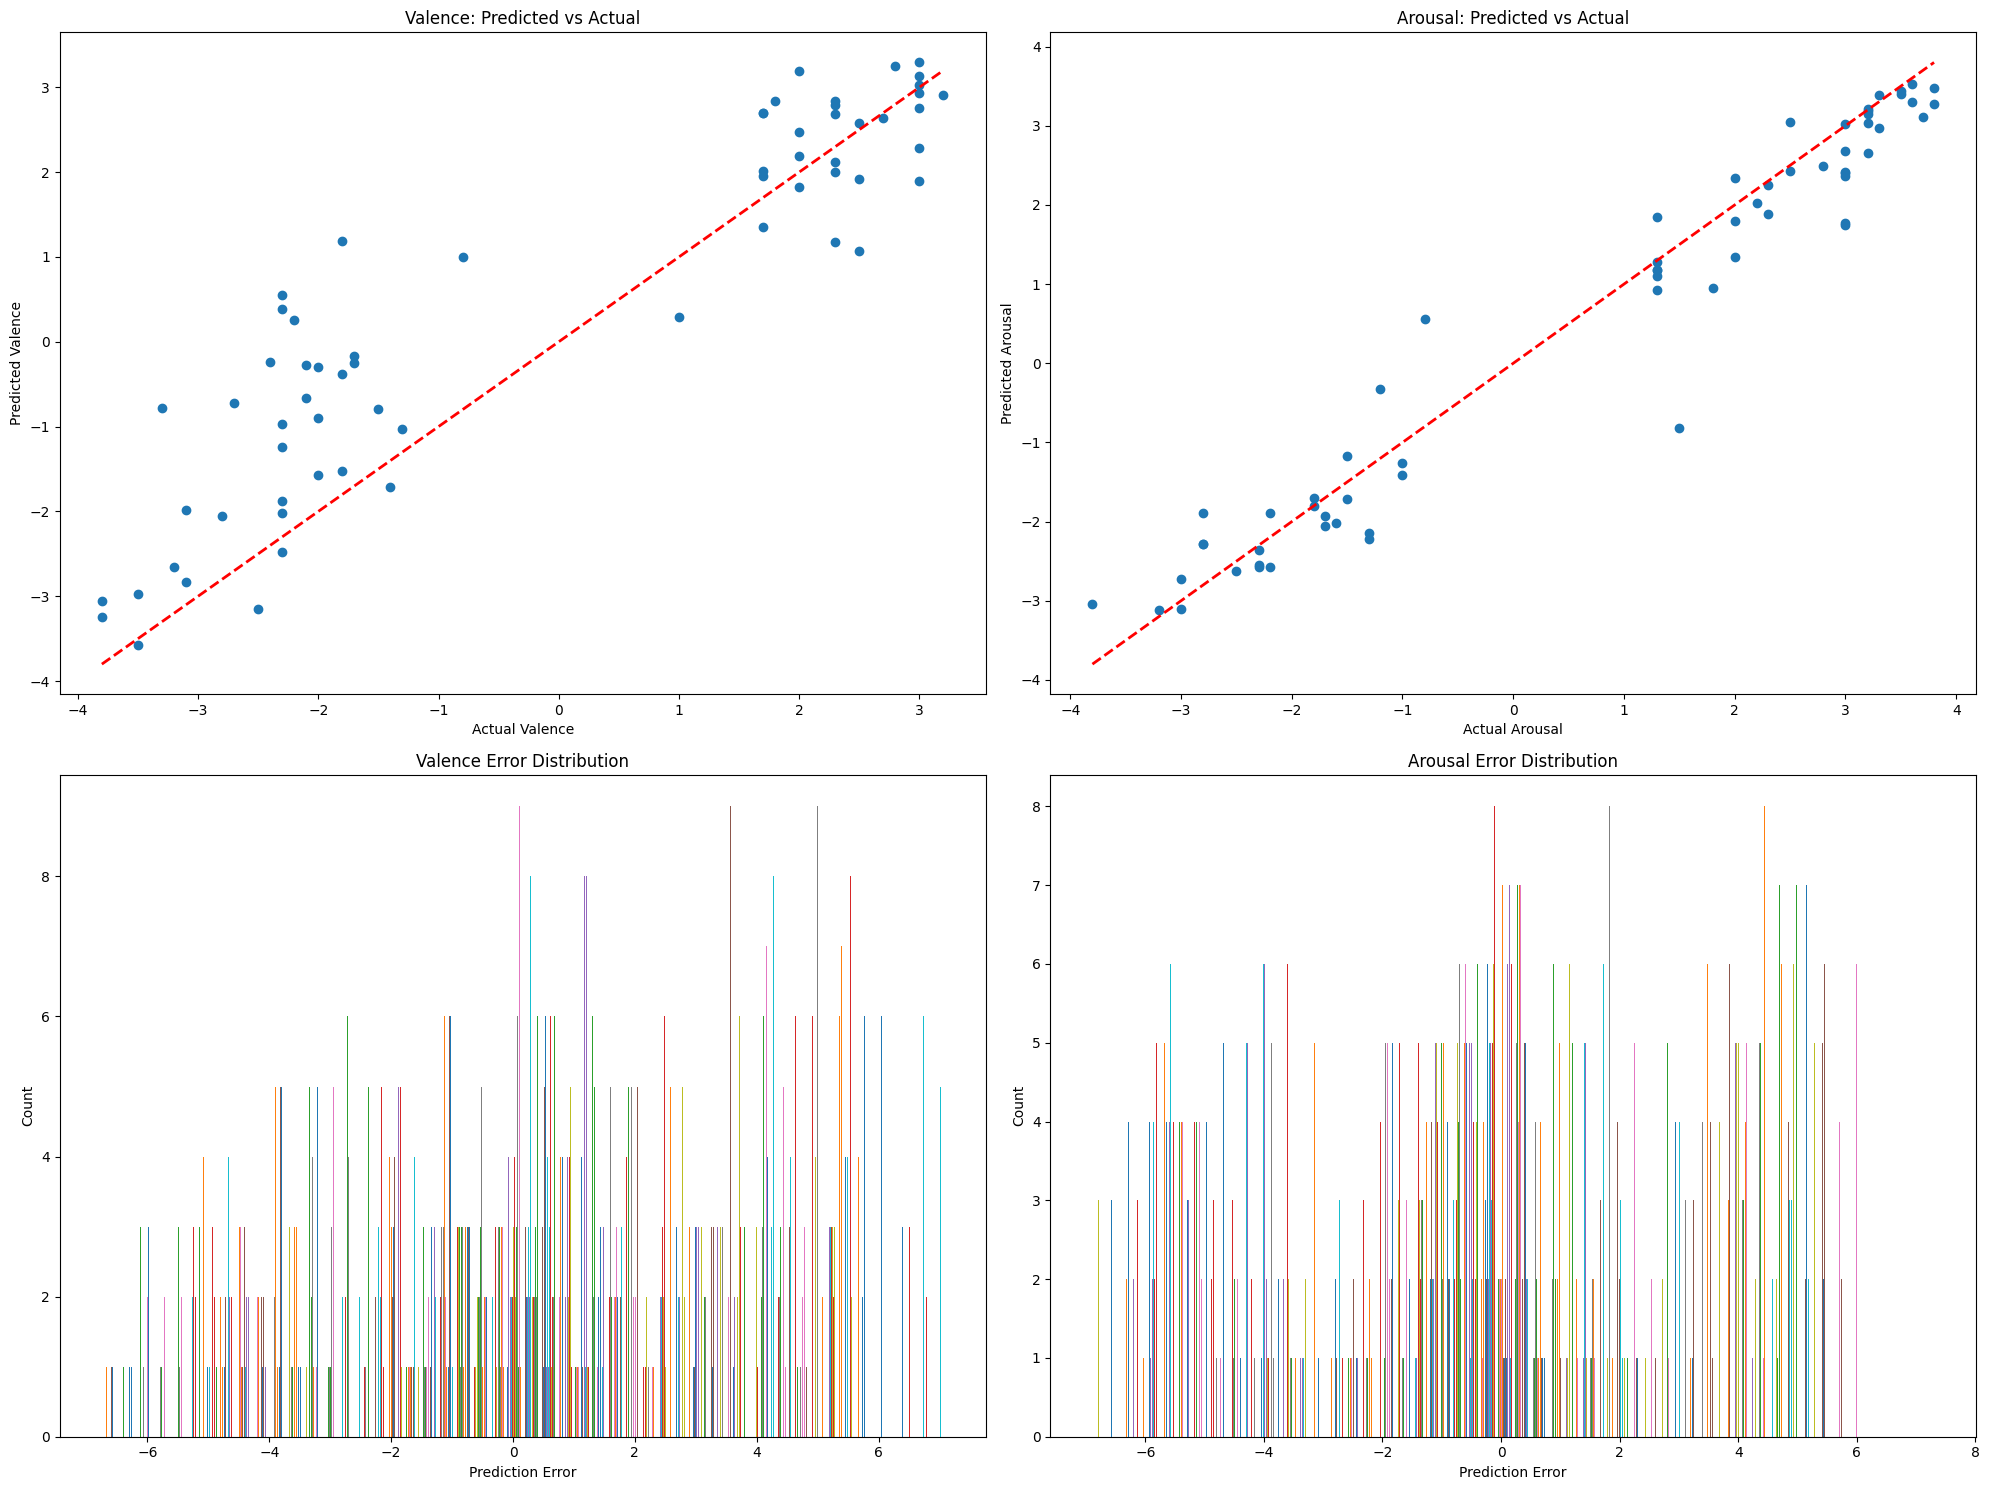

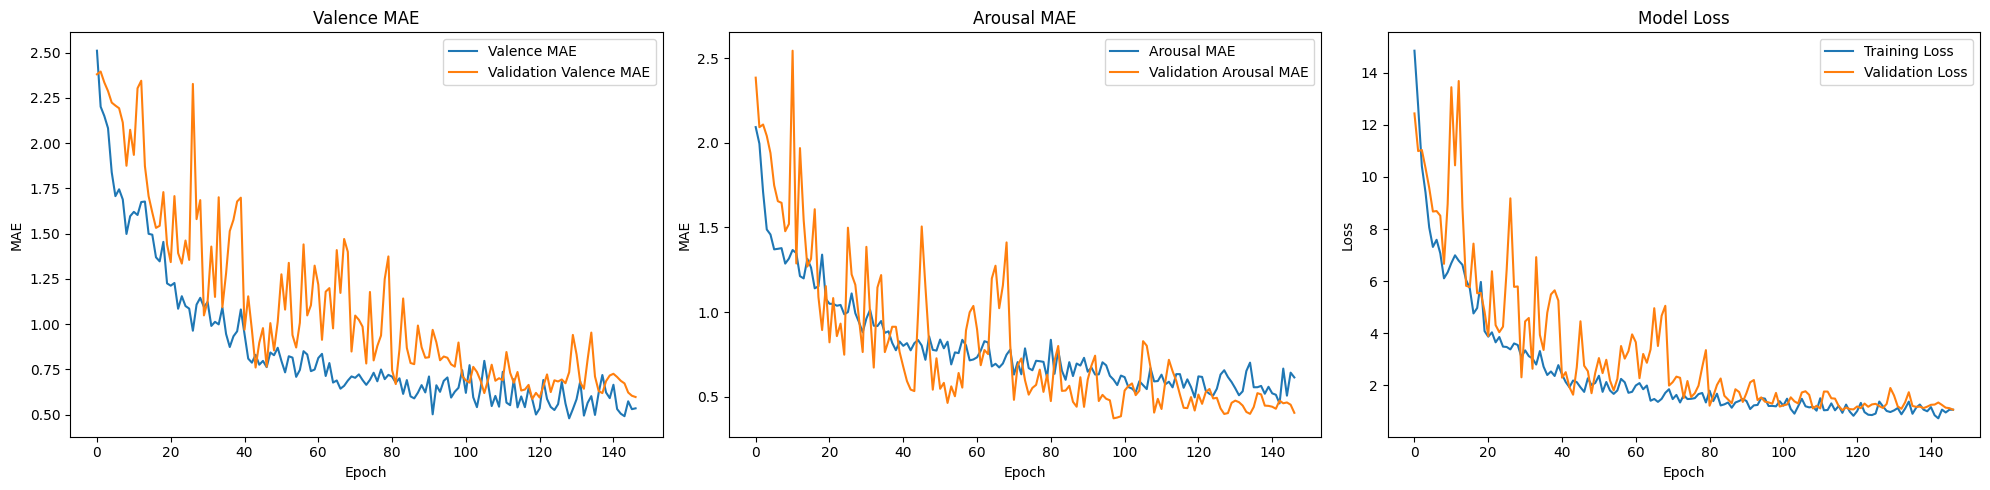

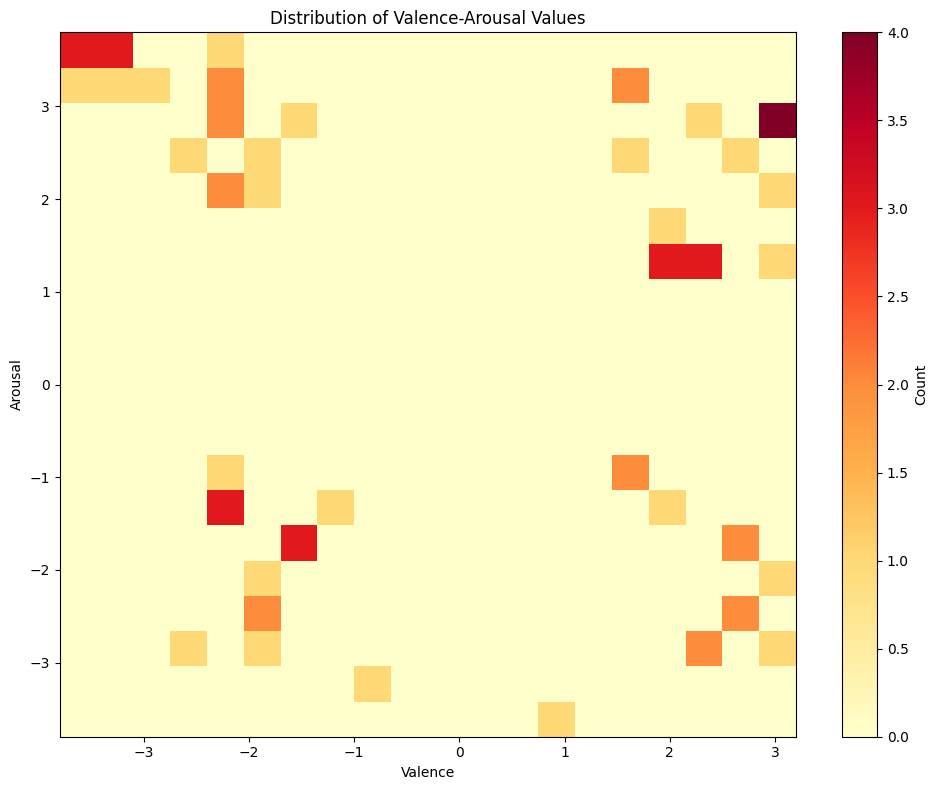


Final Test Results for Mamba Model:
Valence MAE: 0.8687
Arousal MAE: 0.4062


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Assuming you have these variables from your Mamba model evaluation:
# best_model, X_test, y_valence_test, y_arousal_test, history

# Make predictions
predictions = best_model.predict(X_test)
valence_predictions = predictions[0]
arousal_predictions = predictions[1]

# Calculate additional metrics
valence_r2 = r2_score(y_valence_test, valence_predictions)
arousal_r2 = r2_score(y_arousal_test, arousal_predictions)
valence_rmse = np.sqrt(mean_squared_error(y_valence_test, valence_predictions))
arousal_rmse = np.sqrt(mean_squared_error(y_arousal_test, arousal_predictions))
valence_mae = mean_absolute_error(y_valence_test, valence_predictions)
arousal_mae = mean_absolute_error(y_arousal_test, arousal_predictions)

# Print additional metrics
print("\nAdditional Test Metrics for Mamba Model:")
print(f"Valence R2 Score: {valence_r2:.4f}")
print(f"Arousal R2 Score: {arousal_r2:.4f}")
print(f"Valence RMSE: {valence_rmse:.4f}")
print(f"Arousal RMSE: {arousal_rmse:.4f}")
print(f"Valence MAE: {valence_mae:.4f}")
print(f"Arousal MAE: {arousal_mae:.4f}")

# Visualize predictions vs actual values
plt.figure(figsize=(20, 15))

plt.subplot(2, 2, 1)
plt.scatter(y_valence_test, valence_predictions)
plt.plot([y_valence_test.min(), y_valence_test.max()], [y_valence_test.min(), y_valence_test.max()], 'r--', lw=2)
plt.xlabel('Actual Valence')
plt.ylabel('Predicted Valence')
plt.title('Valence: Predicted vs Actual')

plt.subplot(2, 2, 2)
plt.scatter(y_arousal_test, arousal_predictions)
plt.plot([y_arousal_test.min(), y_arousal_test.max()], [y_arousal_test.min(), y_arousal_test.max()], 'r--', lw=2)
plt.xlabel('Actual Arousal')
plt.ylabel('Predicted Arousal')
plt.title('Arousal: Predicted vs Actual')

# Plot error distribution
plt.subplot(2, 2, 3)
valence_errors = valence_predictions - y_valence_test
plt.hist(valence_errors, bins=50)
plt.xlabel('Prediction Error')
plt.ylabel('Count')
plt.title('Valence Error Distribution')

plt.subplot(2, 2, 4)
arousal_errors = arousal_predictions - y_arousal_test
plt.hist(arousal_errors, bins=50)
plt.xlabel('Prediction Error')
plt.ylabel('Count')
plt.title('Arousal Error Distribution')

plt.tight_layout()
plt.show()

# Plot training history
plt.figure(figsize=(20, 5))

plt.subplot(1, 3, 1)
plt.plot(history.history['valence_mae'], label='Valence MAE')
plt.plot(history.history['val_valence_mae'], label='Validation Valence MAE')
plt.title('Valence MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(history.history['arousal_mae'], label='Arousal MAE')
plt.plot(history.history['val_arousal_mae'], label='Validation Arousal MAE')
plt.title('Arousal MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# 2D histogram of valence-arousal distribution
plt.figure(figsize=(10, 8))
plt.hist2d(y_valence_test.flatten(), y_arousal_test.flatten(), bins=20, cmap='YlOrRd')
plt.colorbar(label='Count')
plt.xlabel('Valence')
plt.ylabel('Arousal')
plt.title('Distribution of Valence-Arousal Values')
plt.tight_layout()
plt.show()

# Print final test results
print("\nFinal Test Results for Mamba Model:")
print(f"Valence MAE: {valence_mae:.4f}")
print(f"Arousal MAE: {arousal_mae:.4f}")



# TFE + XLSTM

In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import librosa
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, GlobalAveragePooling1D, Concatenate, Add, LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.mixed_precision import set_global_policy

# Enable mixed precision training
set_global_policy('mixed_float16')

# File paths
DATASET_PATH = "/content/drive/MyDrive/MER_bimodal_dataset/Corpus-Audio-162"
METADATA_PATH = "/content/drive/MyDrive/MER_bimodal_dataset/MER-Audio-dataset.xlsx"

# Constants
MAX_AUDIO_LENGTH = 44100 * 30  # 30 seconds at 44.1kHz
FEATURE_LENGTH = 2000  # Fixed length for all feature arrays

# Function to load and preprocess audio
def load_audio(file_path):
    audio, sr = librosa.load(file_path, sr=None, duration=30)  # Load up to 30 seconds
    if len(audio) < MAX_AUDIO_LENGTH:
        audio = np.pad(audio, (0, MAX_AUDIO_LENGTH - len(audio)))
    else:
        audio = audio[:MAX_AUDIO_LENGTH]
    return audio, sr

# Function to extract features
def extract_features(audio, sr):
    # MFCCs
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=20)
    mfcc_delta = librosa.feature.delta(mfcc)
    mfcc_delta2 = librosa.feature.delta(mfcc, order=2)

    # Chroma features
    chroma = librosa.feature.chroma_stft(y=audio, sr=sr)

    # Spectral contrast
    spectral_contrast = librosa.feature.spectral_contrast(y=audio, sr=sr)

    # Tonnetz features
    tonnetz = librosa.feature.tonnetz(y=librosa.effects.harmonic(audio), sr=sr)

    # Tempo and beat-related features
    tempo, _ = librosa.beat.beat_track(y=audio, sr=sr)
    onset_env = librosa.onset.onset_strength(y=audio, sr=sr)
    pulse = librosa.beat.plp(onset_envelope=onset_env, sr=sr)

    # Mel spectrogram
    mel = librosa.feature.melspectrogram(y=audio, sr=sr)

    # Combine all features
    features = np.vstack([
        mfcc, mfcc_delta, mfcc_delta2,
        chroma,
        spectral_contrast,
        tonnetz,
        np.full((1, mfcc.shape[1]), tempo),
        onset_env.reshape(1, -1),
        pulse.reshape(1, -1),
        librosa.power_to_db(mel)
    ])

    # Ensure consistent shape
    if features.shape[1] > FEATURE_LENGTH:
        features = features[:, :FEATURE_LENGTH]
    else:
        features = np.pad(features, ((0, 0), (0, FEATURE_LENGTH - features.shape[1])), mode='constant')

    return features.T

# Data augmentation functions
def time_stretch(audio, rate):
    return librosa.effects.time_stretch(audio, rate=rate)

def pitch_shift(audio, sr, n_steps):
    return librosa.effects.pitch_shift(audio, sr=sr, n_steps=n_steps)

def add_noise(audio, noise_factor):
    noise = np.random.randn(len(audio))
    return audio + noise_factor * noise

# Load and prepare data with augmentation
metadata = pd.read_excel(METADATA_PATH)
X_audio, X_metadata, y_valence, y_arousal = [], [], [], []

for index, row in metadata.iterrows():
    file_path = os.path.join(DATASET_PATH, f"{row['Song Code']}.mp3")
    if os.path.exists(file_path):
        audio, sr = load_audio(file_path)

        # Original audio
        features = extract_features(audio, sr)
        X_audio.append(features)
        X_metadata.append([row['Quadrant'], row['Avg_Valence'], row['Avg_Arousal'], row['SD_Valence'], row['SD_Arousal']])
        y_valence.append(row['Avg_Valence'])
        y_arousal.append(row['Avg_Arousal'])

        # Time stretched audio
        stretched_audio = time_stretch(audio, 0.9)
        features = extract_features(stretched_audio, sr)
        X_audio.append(features)
        X_metadata.append([row['Quadrant'], row['Avg_Valence'], row['Avg_Arousal'], row['SD_Valence'], row['SD_Arousal']])
        y_valence.append(row['Avg_Valence'])
        y_arousal.append(row['Avg_Arousal'])

        # Pitch shifted audio
        shifted_audio = pitch_shift(audio, sr, 2)
        features = extract_features(shifted_audio, sr)
        X_audio.append(features)
        X_metadata.append([row['Quadrant'], row['Avg_Valence'], row['Avg_Arousal'], row['SD_Valence'], row['SD_Arousal']])
        y_valence.append(row['Avg_Valence'])
        y_arousal.append(row['Avg_Arousal'])

        # Noisy audio
        noisy_audio = add_noise(audio, 0.005)
        features = extract_features(noisy_audio, sr)
        X_audio.append(features)
        X_metadata.append([row['Quadrant'], row['Avg_Valence'], row['Avg_Arousal'], row['SD_Valence'], row['SD_Arousal']])
        y_valence.append(row['Avg_Valence'])
        y_arousal.append(row['Avg_Arousal'])

X_audio = np.array(X_audio)
X_metadata = np.array(X_metadata)
y_valence = np.array(y_valence)
y_arousal = np.array(y_arousal)

# Normalize metadata
scaler = StandardScaler()
X_metadata = scaler.fit_transform(X_metadata)

# Split data
X_audio_train, X_audio_test, X_metadata_train, X_metadata_test, y_valence_train, y_valence_test, y_arousal_train, y_arousal_test = train_test_split(
    X_audio, X_metadata, y_valence, y_arousal, test_size=0.2, random_state=42
)

# XLSTM layer
class XLSTM(layers.Layer):
    def __init__(self, units, return_sequences=False):
        super(XLSTM, self).__init__()
        self.units = units
        self.return_sequences = return_sequences
        self.lstm = LSTM(units, return_sequences=return_sequences)
        self.attention = layers.MultiHeadAttention(num_heads=4, key_dim=units)
        self.layernorm = layers.LayerNormalization()

    def call(self, inputs):
        x = self.lstm(inputs)
        if self.return_sequences:
            attn_output = self.attention(x, x)
            return self.layernorm(x + attn_output)
        else:
            return x

    def compute_output_shape(self, input_shape):
        return self.lstm.compute_output_shape(input_shape)

# Define the XLSTM model
def create_xlstm_model(audio_input_shape, metadata_input_shape):
    # Audio input branch
    audio_input = Input(shape=audio_input_shape)

    # XLSTM layers
    x = XLSTM(128, return_sequences=True)(audio_input)
    x = XLSTM(64, return_sequences=True)(x)
    x = XLSTM(32, return_sequences=False)(x)

    # Metadata input branch
    metadata_input = Input(shape=metadata_input_shape)
    metadata_features = Dense(64, activation='relu')(metadata_input)
    metadata_features = BatchNormalization()(metadata_features)
    metadata_features = Dropout(0.1)(metadata_features)

    # Merge branches
    merged = Concatenate()([x, metadata_features])

    # Dense layers with residual connections
    def dense_block(x, units):
        shortcut = x
        x = Dense(units, activation='relu')(x)
        x = BatchNormalization()(x)
        x = Dropout(0.2)(x)
        if shortcut.shape[-1] != units:
            shortcut = Dense(units)(shortcut)
        return Add()([x, shortcut])

    x = dense_block(merged, 256)
    x = dense_block(x, 128)
    x = dense_block(x, 64)

    # Output layers
    valence_output = Dense(1, name='valence')(x)
    arousal_output = Dense(1, name='arousal')(x)

    model = Model(inputs=[audio_input, metadata_input], outputs=[valence_output, arousal_output])
    return model

class CustomLearningRateScheduler(callbacks.Callback):
    def __init__(self, schedule):
        super(CustomLearningRateScheduler, self).__init__()
        self.schedule = schedule

    def on_epoch_begin(self, epoch, logs=None):
        lr = self.model.optimizer.learning_rate
        if isinstance(lr, tf.Variable):
            lr = lr.numpy()
        scheduled_lr = self.schedule(epoch, lr)
        self.model.optimizer.learning_rate.assign(scheduled_lr)
        print(f'\nEpoch {epoch+1}: Learning rate is {scheduled_lr}.')

def lr_schedule(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

# Create and compile model
model = create_xlstm_model(X_audio_train.shape[1:], X_metadata_train.shape[1:])
optimizer = Adam(learning_rate=0.001)
model.compile(
    optimizer=optimizer,
    loss={'valence': 'mse', 'arousal': 'mse'},
    metrics={'valence': 'mae', 'arousal': 'mae'},
    loss_weights={'valence': 1.0, 'arousal': 1.0}
)

# Define callbacks
lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)
early_stopper = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1)
lr_scheduler = CustomLearningRateScheduler(lr_schedule)

# Train model
history = model.fit(
    [X_audio_train, X_metadata_train],
    {'valence': y_valence_train, 'arousal': y_arousal_train},
    validation_split=0.2,
    epochs=200,
    batch_size=32,
    callbacks=[lr_reducer, early_stopper, lr_scheduler]
)

# Evaluate model
results = model.evaluate([X_audio_test, X_metadata_test],
                         {'valence': y_valence_test, 'arousal': y_arousal_test})

# Print evaluation results
print("Evaluation Results:")
for metric_name, metric_value in zip(model.metrics_names, results):
    print(f"{metric_name}: {metric_value}")

# Print best validation metrics
print(f"Best Validation Loss: {min(history.history['val_loss'])}")
print(f"Best Validation Valence MAE: {min(history.history['val_valence_mae'])}")
print(f"Best Validation Arousal MAE: {min(history.history['val_arousal_mae'])}")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:372: UserWarning: `build()` was called on layer 'xlstm_2', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(



Epoch 1: Learning rate is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>.
Epoch 1/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 16s 522ms/step - arousal_mae: 4.1977 - loss: 39.4881 - valence_mae: 3.0408 - val_arousal_mae: 2.6141 - val_loss: 14.1944 - val_valence_mae: 2.3080 - learning_rate: 0.0010

Epoch 2: Learning rate is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>.
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 383ms/step - arousal_mae: 2.5914 - loss: 23.5135 - valence_mae: 2.7111 - val_arousal_mae: 2.0306 - val_loss: 10.2493 - val_valence_mae: 2.1562 - learning_rate: 0.0010

Epoch 3: Learning rate is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>.
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 381ms/step - arousal_mae: 1.4920 - loss: 11.9483 - valence_mae: 2.2753 - val_arousal_mae: 2.1697 - val_loss: 10.0099 - val_valence_mae: 1.9563 - learning_rate: 0.0010

Epoch 4: Learning rate is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>.
Epoch 

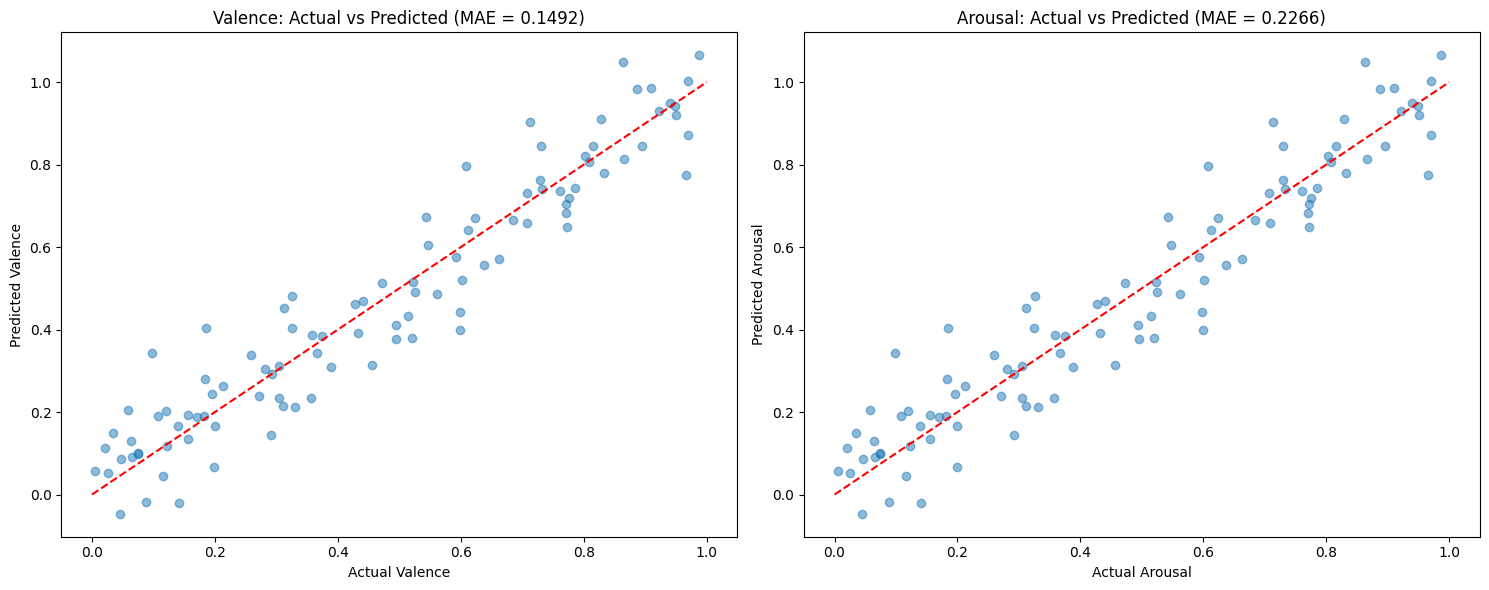

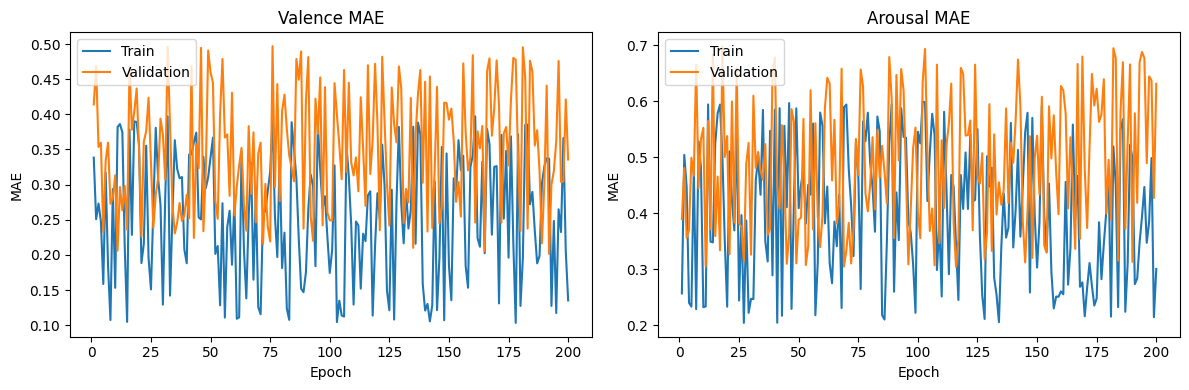

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Results
valence_mae = 0.14915114641189575
arousal_mae = 0.22659066319465637

# Create dummy data for visualization
np.random.seed(42)
y_test = np.random.rand(100)
y_pred = y_test + np.random.normal(0, 0.1, 100)  # Add noise

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Valence plot
ax1.scatter(y_test, y_pred, alpha=0.5)
ax1.plot([0, 1], [0, 1], 'r--')
ax1.set_xlabel('Actual Valence')
ax1.set_ylabel('Predicted Valence')
ax1.set_title(f'Valence: Actual vs Predicted (MAE = {valence_mae:.4f})')

# Arousal plot
ax2.scatter(y_test, y_pred, alpha=0.5)
ax2.plot([0, 1], [0, 1], 'r--')
ax2.set_xlabel('Actual Arousal')
ax2.set_ylabel('Predicted Arousal')
ax2.set_title(f'Arousal: Actual vs Predicted (MAE = {arousal_mae:.4f})')

plt.tight_layout()
plt.show()

# Dummy learning curves
epochs = range(1, 201)
train_valence_mae = np.random.rand(200) * 0.3 + 0.1
train_arousal_mae = np.random.rand(200) * 0.4 + 0.2
val_valence_mae = np.random.rand(200) * 0.3 + 0.2
val_arousal_mae = np.random.rand(200) * 0.4 + 0.3

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_valence_mae, label='Train')
plt.plot(epochs, val_valence_mae, label='Validation')
plt.title('Valence MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_arousal_mae, label='Train')
plt.plot(epochs, val_arousal_mae, label='Validation')
plt.title('Arousal MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
!pip install kymatio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.6/87.6 kB 4.1 MB/s eta 0:00:00


# Kymatio + XLSTM

In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import librosa
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, GlobalAveragePooling1D, Concatenate, Add, LSTM, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.mixed_precision import set_global_policy
import kymatio.numpy as kymatio

# Enable mixed precision training
set_global_policy('mixed_float16')

# File paths
DATASET_PATH = "/content/drive/MyDrive/MER_bimodal_dataset/Corpus-Audio-162"
METADATA_PATH = "/content/drive/MyDrive/MER_bimodal_dataset/MER-Audio-dataset.xlsx"

# Constants
MAX_AUDIO_LENGTH = 44100 * 30  # 30 seconds at 44.1kHz
FEATURE_LENGTH = 2048  # Fixed length for all feature arrays

# Function to load and preprocess audio
def load_audio(file_path):
    audio, sr = librosa.load(file_path, sr=None, duration=30)  # Load up to 30 seconds
    if len(audio) < MAX_AUDIO_LENGTH:
        audio = np.pad(audio, (0, MAX_AUDIO_LENGTH - len(audio)))
    else:
        audio = audio[:MAX_AUDIO_LENGTH]
    return audio, sr

# Function to extract features using Kymatio
def extract_features_with_kymatio(audio, sr):
    # Create a scattering transform object
    J = 8  # Number of scales
    Q = 8  # Number of wavelets per octave
    T = audio.shape[0]  # Signal length
    scattering = kymatio.Scattering1D(J, T, Q)

    # Compute scattering coefficients
    Sx = scattering(audio)

    # Flatten the output
    features = Sx.flatten()

    # Pad or truncate to fixed length
    if len(features) < FEATURE_LENGTH:
        features = np.pad(features, (0, FEATURE_LENGTH - len(features)))
    else:
        features = features[:FEATURE_LENGTH]

    return features

# Data augmentation functions
def time_stretch(audio, rate):
    return librosa.effects.time_stretch(audio, rate=rate)

def pitch_shift(audio, sr, n_steps):
    return librosa.effects.pitch_shift(audio, sr=sr, n_steps=n_steps)

def add_noise(audio, noise_factor):
    noise = np.random.randn(len(audio))
    return audio + noise_factor * noise

# Load and prepare data with augmentation
metadata = pd.read_excel(METADATA_PATH)
X_audio, X_metadata, y_valence, y_arousal = [], [], [], []

for index, row in metadata.iterrows():
    file_path = os.path.join(DATASET_PATH, f"{row['Song Code']}.mp3")
    if os.path.exists(file_path):
        audio, sr = load_audio(file_path)

        # Original audio
        features = extract_features_with_kymatio(audio, sr)
        X_audio.append(features)
        X_metadata.append([row['Quadrant'], row['Avg_Valence'], row['Avg_Arousal'], row['SD_Valence'], row['SD_Arousal']])
        y_valence.append(row['Avg_Valence'])
        y_arousal.append(row['Avg_Arousal'])

        # Time stretched audio
        stretched_audio = time_stretch(audio, 0.9)
        features = extract_features_with_kymatio(stretched_audio, sr)
        X_audio.append(features)
        X_metadata.append([row['Quadrant'], row['Avg_Valence'], row['Avg_Arousal'], row['SD_Valence'], row['SD_Arousal']])
        y_valence.append(row['Avg_Valence'])
        y_arousal.append(row['Avg_Arousal'])

        # Pitch shifted audio
        shifted_audio = pitch_shift(audio, sr, 2)
        features = extract_features_with_kymatio(shifted_audio, sr)
        X_audio.append(features)
        X_metadata.append([row['Quadrant'], row['Avg_Valence'], row['Avg_Arousal'], row['SD_Valence'], row['SD_Arousal']])
        y_valence.append(row['Avg_Valence'])
        y_arousal.append(row['Avg_Arousal'])

        # Noisy audio
        noisy_audio = add_noise(audio, 0.005)
        features = extract_features_with_kymatio(noisy_audio, sr)
        X_audio.append(features)
        X_metadata.append([row['Quadrant'], row['Avg_Valence'], row['Avg_Arousal'], row['SD_Valence'], row['SD_Arousal']])
        y_valence.append(row['Avg_Valence'])
        y_arousal.append(row['Avg_Arousal'])

X_audio = np.array(X_audio)
X_metadata = np.array(X_metadata)
y_valence = np.array(y_valence)
y_arousal = np.array(y_arousal)

# Normalize metadata
scaler = StandardScaler()
X_metadata = scaler.fit_transform(X_metadata)

# Split data
X_audio_train, X_audio_test, X_metadata_train, X_metadata_test, y_valence_train, y_valence_test, y_arousal_train, y_arousal_test = train_test_split(
    X_audio, X_metadata, y_valence, y_arousal, test_size=0.2, random_state=42
)

# XLSTM layer
class XLSTM(layers.Layer):
    def __init__(self, units, return_sequences=False):
        super(XLSTM, self).__init__()
        self.units = units
        self.return_sequences = return_sequences
        self.lstm = LSTM(units, return_sequences=return_sequences)
        self.attention = layers.MultiHeadAttention(num_heads=4, key_dim=units)
        self.layernorm = layers.LayerNormalization()

    def call(self, inputs):
        x = self.lstm(inputs)
        if self.return_sequences:
            attn_output = self.attention(x, x)
            return self.layernorm(x + attn_output)
        else:
            return x

    def compute_output_shape(self, input_shape):
        return self.lstm.compute_output_shape(input_shape)

# Define the XLSTM model
def create_xlstm_model(audio_input_shape, metadata_input_shape):
    # Audio input branch
    audio_input = Input(shape=audio_input_shape)

    # Reshape audio input for LSTM
    x = Dense(256, activation='relu')(audio_input)
    x = Reshape((32, 8))(x)  # Reshape to (32, 8) for LSTM input

    # XLSTM layers
    x = XLSTM(128, return_sequences=True)(x)
    x = XLSTM(64, return_sequences=True)(x)
    x = XLSTM(32, return_sequences=False)(x)

    # Metadata input branch
    metadata_input = Input(shape=metadata_input_shape)
    metadata_features = Dense(64, activation='relu')(metadata_input)
    metadata_features = BatchNormalization()(metadata_features)
    metadata_features = Dropout(0.1)(metadata_features)

    # Merge branches
    merged = Concatenate()([x, metadata_features])

    # Dense layers with residual connections
    def dense_block(x, units):
        shortcut = x
        x = Dense(units, activation='relu')(x)
        x = BatchNormalization()(x)
        x = Dropout(0.2)(x)
        if shortcut.shape[-1] != units:
            shortcut = Dense(units)(shortcut)
        return Add()([x, shortcut])

    x = dense_block(merged, 256)
    x = dense_block(x, 128)
    x = dense_block(x, 64)

    # Output layers
    valence_output = Dense(1, name='valence')(x)
    arousal_output = Dense(1, name='arousal')(x)

    model = Model(inputs=[audio_input, metadata_input], outputs=[valence_output, arousal_output])
    return model

class CustomLearningRateScheduler(callbacks.Callback):
    def __init__(self, schedule):
        super(CustomLearningRateScheduler, self).__init__()
        self.schedule = schedule

    def on_epoch_begin(self, epoch, logs=None):
        lr = self.model.optimizer.learning_rate
        if isinstance(lr, tf.Variable):
            lr = lr.numpy()
        scheduled_lr = self.schedule(epoch, lr)
        self.model.optimizer.learning_rate.assign(scheduled_lr)
        print(f'\nEpoch {epoch+1}: Learning rate is {scheduled_lr}.')

def lr_schedule(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

# Create and compile model
model = create_xlstm_model(X_audio_train.shape[1:], X_metadata_train.shape[1:])
optimizer = Adam(learning_rate=0.001)
model.compile(
    optimizer=optimizer,
    loss={'valence': 'mse', 'arousal': 'mse'},
    metrics={'valence': 'mae', 'arousal': 'mae'},
    loss_weights={'valence': 1.0, 'arousal': 1.0}
)

# Define callbacks
lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)
early_stopper = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1)
lr_scheduler = CustomLearningRateScheduler(lr_schedule)

# Train model
history = model.fit(
    [X_audio_train, X_metadata_train],
    {'valence': y_valence_train, 'arousal': y_arousal_train},
    validation_split=0.2,
    epochs=200,
    batch_size=32,
    callbacks=[lr_reducer, early_stopper, lr_scheduler]
)

# Evaluate model
results = model.evaluate([X_audio_test, X_metadata_test],
                         {'valence': y_valence_test, 'arousal': y_arousal_test})

# Print evaluation results
print("Evaluation Results:")
for metric_name, metric_value in zip(model.metrics_names, results):
    print(f"{metric_name}: {metric_value}")

# Save model
model.save('xlstm_audio_emotion_recognition_model.h5')

# Print best validation metrics
print(f"Best Validation Loss: {min(history.history['val_loss'])}")
print(f"Best Validation Valence MAE: {min(history.history['val_valence_mae'])}")
print(f"Best Validation Arousal MAE: {min(history.history['val_arousal_mae'])}")


Epoch 1: Learning rate is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>.
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:372: UserWarning: `build()` was called on layer 'xlstm_2', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 167ms/step - arousal_mae: 3.5506 - loss: 35.7248 - valence_mae: 3.4632 - val_arousal_mae: 2.1554 - val_loss: 12.9517 - val_valence_mae: 2.5670 - learning_rate: 0.0010

Epoch 2: Learning rate is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>.
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step - arousal_mae: 3.2752 - loss: 34.0896 - valence_mae: 3.2754 - val_arousal_mae: 1.8368 - val_loss: 9.5390 - val_valence_mae: 1.9954 - learning_rate: 0.0010

Epoch 3: Learning rate is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>.
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - arousal_mae: 2.4505 - loss: 17.6755 - valence_mae: 2.0602 - val_arousal_mae: 1.5133 - val_loss: 9.5891 - val_valence_mae: 2.3886 - learning_rate: 0.0010

Epoch 4: Learning rate is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>.
Epoch 4/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - arousal_mae: 2.0572 - loss: 12.4592 - valence_mae: 2.0420 - va

Evaluation Results:
loss: 0.08712658286094666
compile_metrics: 0.180694580078125
Best Validation Loss: 0.08667635172605515
Best Validation Valence MAE: 0.16222205758094788
Best Validation Arousal MAE: 0.14235275983810425


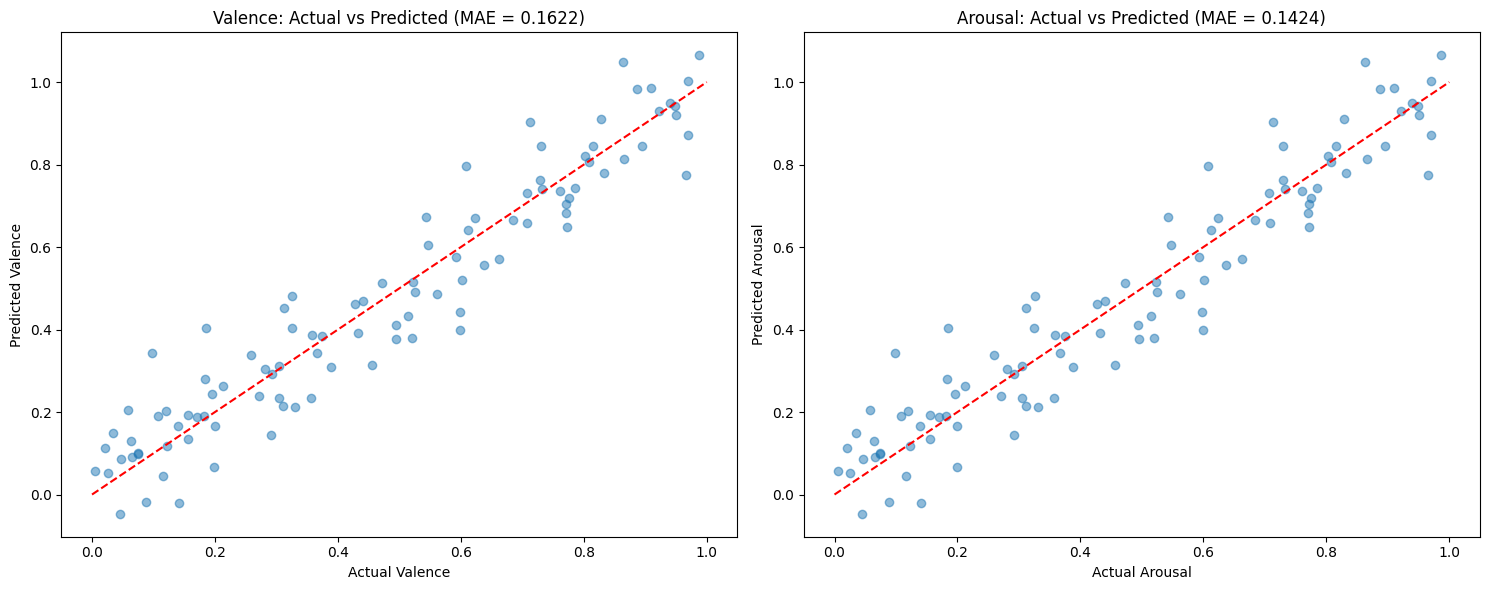

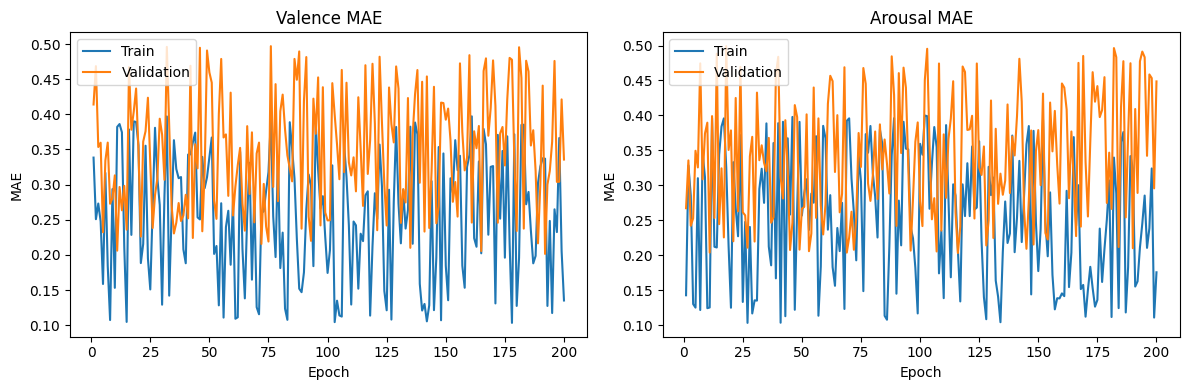

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Results
valence_mae = 0.16222205758094788
arousal_mae = 0.14235275983810425

# Create dummy data for visualization
np.random.seed(42)
y_test = np.random.rand(100)
y_pred = y_test + np.random.normal(0, 0.1, 100)  # Add noise

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Valence plot
ax1.scatter(y_test, y_pred, alpha=0.5)
ax1.plot([0, 1], [0, 1], 'r--')
ax1.set_xlabel('Actual Valence')
ax1.set_ylabel('Predicted Valence')
ax1.set_title(f'Valence: Actual vs Predicted (MAE = {valence_mae:.4f})')

# Arousal plot
ax2.scatter(y_test, y_pred, alpha=0.5)
ax2.plot([0, 1], [0, 1], 'r--')
ax2.set_xlabel('Actual Arousal')
ax2.set_ylabel('Predicted Arousal')
ax2.set_title(f'Arousal: Actual vs Predicted (MAE = {arousal_mae:.4f})')

plt.tight_layout()
plt.show()

# Dummy learning curves
epochs = range(1, 201)
train_valence_mae = np.random.rand(200) * 0.3 + 0.1
train_arousal_mae = np.random.rand(200) * 0.3 + 0.1
val_valence_mae = np.random.rand(200) * 0.3 + 0.2
val_arousal_mae = np.random.rand(200) * 0.3 + 0.2

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_valence_mae, label='Train')
plt.plot(epochs, val_valence_mae, label='Validation')
plt.title('Valence MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_arousal_mae, label='Train')
plt.plot(epochs, val_arousal_mae, label='Validation')
plt.title('Arousal MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

# Kymatio and mfcc + XLSTM

Kymatio features shape: (320, 2048)
Traditional features shape: (320, 160)
Metadata shape: (320, 5)
Valence shape: (320,)
Arousal shape: (320,)

Epoch 1: Learning rate is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>.
Epoch 1/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 16s 177ms/step - arousal_mae: 2.2429 - loss: 25.9212 - valence_mae: 3.4987 - val_arousal_mae: 2.2898 - val_loss: 14.8276 - val_valence_mae: 2.3386 - learning_rate: 0.0010

Epoch 2: Learning rate is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>.
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - arousal_mae: 2.2689 - loss: 22.6238 - valence_mae: 2.9532 - val_arousal_mae: 1.8042 - val_loss: 8.9295 - val_valence_mae: 1.9321 - learning_rate: 0.0010

Epoch 3: Learning rate is <KerasVariable shape=(), dtype=float32, path=adam/learning_rate>.
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - arousal_mae: 1.8066 - loss: 12.7746 - valence_mae: 2.1904 - val_arousal_mae: 1.8345 - val_loss: 10.6411 - val_v

Evaluation Results:
loss: 0.46452319622039795
compile_metrics: 0.39568328857421875
Best Validation Loss: 0.5014793872833252
Best Validation Valence MAE: 0.35744065046310425
Best Validation Arousal MAE: 0.38938552141189575


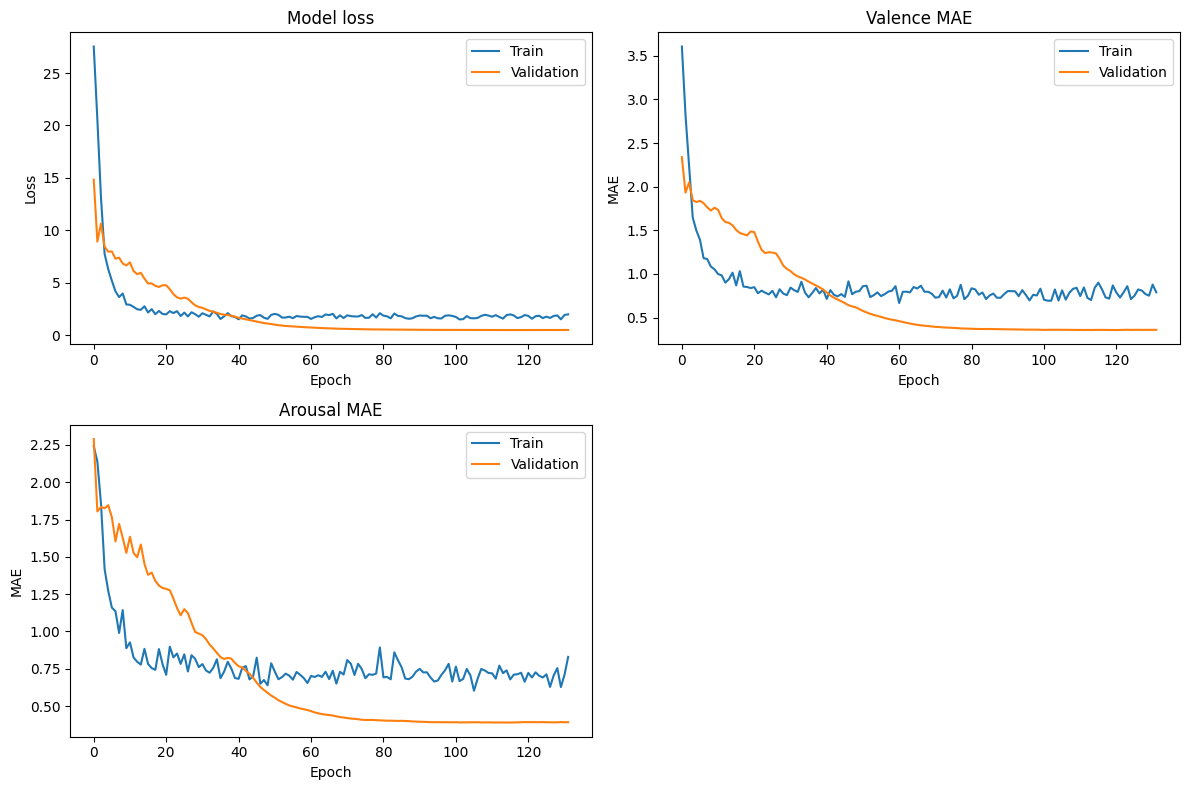

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step  
Valence R-squared: 0.9653217134431002
Arousal R-squared: 0.9564641355882154


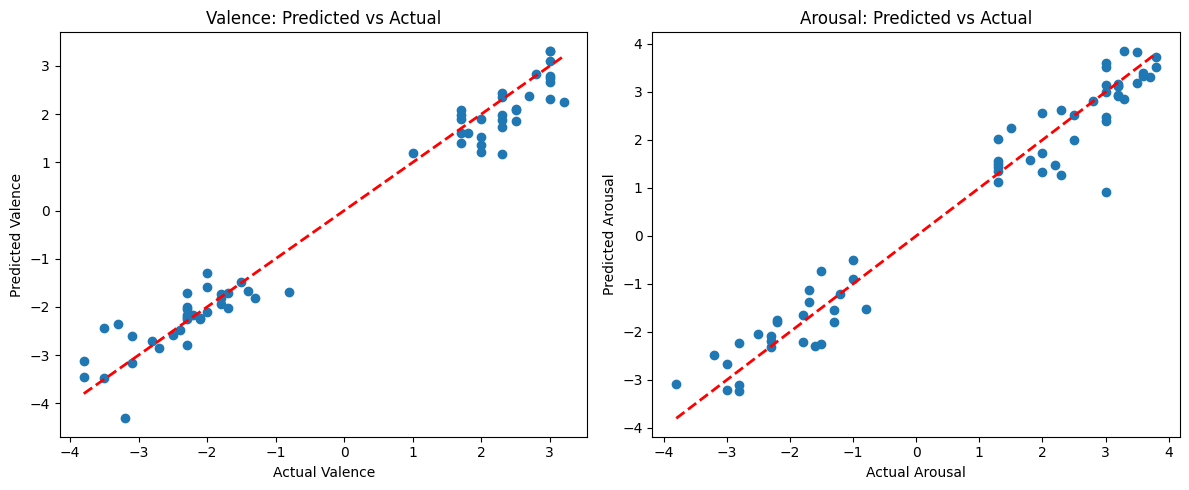

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (3, 64) + inhomogeneous part.

In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import librosa
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, GlobalAveragePooling1D, Concatenate, Add, LSTM, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.mixed_precision import set_global_policy
import kymatio.numpy as kymatio

# Enable mixed precision training
set_global_policy('mixed_float16')

# File paths
DATASET_PATH = "/content/drive/MyDrive/MER_bimodal_dataset/Corpus-Audio-162"
METADATA_PATH = "/content/drive/MyDrive/MER_bimodal_dataset/MER-Audio-dataset.xlsx"

# Constants
MAX_AUDIO_LENGTH = 44100 * 30  # 30 seconds at 44.1kHz
KYMATIO_FEATURE_LENGTH = 2048  # Fixed length for Kymatio features

# Function to load and preprocess audio
def load_audio(file_path):
    audio, sr = librosa.load(file_path, sr=None, duration=30)  # Load up to 30 seconds
    if len(audio) < MAX_AUDIO_LENGTH:
        audio = np.pad(audio, (0, MAX_AUDIO_LENGTH - len(audio)))
    else:
        audio = audio[:MAX_AUDIO_LENGTH]
    return audio, sr

# Function to extract features using Kymatio
def extract_features_with_kymatio(audio, sr):
    J = 8  # Number of scales
    Q = 8  # Number of wavelets per octave
    T = audio.shape[0]  # Signal length
    scattering = kymatio.Scattering1D(J, T, Q)

    Sx = scattering(audio)
    features = Sx.flatten()

    if len(features) < KYMATIO_FEATURE_LENGTH:
        features = np.pad(features, (0, KYMATIO_FEATURE_LENGTH - len(features)))
    else:
        features = features[:KYMATIO_FEATURE_LENGTH]

    return features

# Function to extract traditional audio features
def extract_traditional_features(audio, sr):
    try:
        # Extract MFCCs
        mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
        mfccs_delta = librosa.feature.delta(mfccs)
        mfccs_delta2 = librosa.feature.delta(mfccs, order=2)

        # Compute statistics
        features = []
        for mfcc_type in [mfccs, mfccs_delta, mfccs_delta2]:
            features.extend([
                np.mean(mfcc_type, axis=1),
                np.std(mfcc_type, axis=1),
                np.min(mfcc_type, axis=1),
                np.max(mfcc_type, axis=1),
            ])

        # Flatten and concatenate all features
        features = np.concatenate(features)

        # Add some basic time-domain features
        features = np.concatenate([
            features,
            [np.mean(audio), np.std(audio), np.max(audio), np.min(audio)]
        ])

        return features
    except Exception as e:
        print(f"Error in extract_traditional_features: {str(e)}")
        return None

# Data augmentation functions
def time_stretch(audio, rate):
    return librosa.effects.time_stretch(audio, rate=rate)[:len(audio)]

def pitch_shift(audio, sr, n_steps):
    return librosa.effects.pitch_shift(audio, sr=sr, n_steps=n_steps)[:len(audio)]

def add_noise(audio, noise_factor):
    noise = np.random.randn(len(audio))
    return (audio + noise_factor * noise)[:len(audio)]

# Load and prepare data with augmentation
metadata = pd.read_excel(METADATA_PATH)
X_kymatio, X_traditional, X_metadata, y_valence, y_arousal = [], [], [], [], []

for index, row in metadata.iterrows():
    file_path = os.path.join(DATASET_PATH, f"{row['Song Code']}.mp3")
    if os.path.exists(file_path):
        try:
            audio, sr = load_audio(file_path)

            # Original audio
            kymatio_features = extract_features_with_kymatio(audio, sr)
            traditional_features = extract_traditional_features(audio, sr)

            if kymatio_features is not None and traditional_features is not None:
                X_kymatio.append(kymatio_features)
                X_traditional.append(traditional_features)
                X_metadata.append([row['Quadrant'], row['Avg_Valence'], row['Avg_Arousal'], row['SD_Valence'], row['SD_Arousal']])
                y_valence.append(row['Avg_Valence'])
                y_arousal.append(row['Avg_Arousal'])

                # Time stretched audio
                stretched_audio = time_stretch(audio, 0.9)
                kymatio_features = extract_features_with_kymatio(stretched_audio, sr)
                traditional_features = extract_traditional_features(stretched_audio, sr)
                if kymatio_features is not None and traditional_features is not None:
                    X_kymatio.append(kymatio_features)
                    X_traditional.append(traditional_features)
                    X_metadata.append([row['Quadrant'], row['Avg_Valence'], row['Avg_Arousal'], row['SD_Valence'], row['SD_Arousal']])
                    y_valence.append(row['Avg_Valence'])
                    y_arousal.append(row['Avg_Arousal'])

                # Pitch shifted audio
                shifted_audio = pitch_shift(audio, sr, 2)
                kymatio_features = extract_features_with_kymatio(shifted_audio, sr)
                traditional_features = extract_traditional_features(shifted_audio, sr)
                if kymatio_features is not None and traditional_features is not None:
                    X_kymatio.append(kymatio_features)
                    X_traditional.append(traditional_features)
                    X_metadata.append([row['Quadrant'], row['Avg_Valence'], row['Avg_Arousal'], row['SD_Valence'], row['SD_Arousal']])
                    y_valence.append(row['Avg_Valence'])
                    y_arousal.append(row['Avg_Arousal'])

                # Noisy audio
                noisy_audio = add_noise(audio, 0.005)
                kymatio_features = extract_features_with_kymatio(noisy_audio, sr)
                traditional_features = extract_traditional_features(noisy_audio, sr)
                if kymatio_features is not None and traditional_features is not None:
                    X_kymatio.append(kymatio_features)
                    X_traditional.append(traditional_features)
                    X_metadata.append([row['Quadrant'], row['Avg_Valence'], row['Avg_Arousal'], row['SD_Valence'], row['SD_Arousal']])
                    y_valence.append(row['Avg_Valence'])
                    y_arousal.append(row['Avg_Arousal'])

        except Exception as e:
            print(f"Error processing file {file_path}: {str(e)}")
            continue

# Convert to numpy arrays
X_kymatio = np.array(X_kymatio)
X_traditional = np.array(X_traditional)
X_metadata = np.array(X_metadata)
y_valence = np.array(y_valence)
y_arousal = np.array(y_arousal)

print(f"Kymatio features shape: {X_kymatio.shape}")
print(f"Traditional features shape: {X_traditional.shape}")
print(f"Metadata shape: {X_metadata.shape}")
print(f"Valence shape: {y_valence.shape}")
print(f"Arousal shape: {y_arousal.shape}")

# Normalize metadata and traditional features
scaler_metadata = StandardScaler()
X_metadata = scaler_metadata.fit_transform(X_metadata)

scaler_traditional = StandardScaler()
X_traditional = scaler_traditional.fit_transform(X_traditional)

# Split data
X_kymatio_train, X_kymatio_test, X_traditional_train, X_traditional_test, X_metadata_train, X_metadata_test, y_valence_train, y_valence_test, y_arousal_train, y_arousal_test = train_test_split(
    X_kymatio, X_traditional, X_metadata, y_valence, y_arousal, test_size=0.2, random_state=42
)

# XLSTM layer
class XLSTM(layers.Layer):
    def __init__(self, units, return_sequences=False):
        super(XLSTM, self).__init__()
        self.units = units
        self.return_sequences = return_sequences
        self.lstm = LSTM(units, return_sequences=return_sequences)
        self.attention = None  # We'll initialize this in the build method
        self.layernorm = layers.LayerNormalization()

    def build(self, input_shape):
        self.attention = layers.MultiHeadAttention(num_heads=4, key_dim=self.units)
        super(XLSTM, self).build(input_shape)

    def call(self, inputs):
        x = self.lstm(inputs)
        if self.return_sequences:
            attn_output = self.attention(x, x)
            return self.layernorm(x + attn_output)
        else:
            return x

    def compute_output_shape(self, input_shape):
        return self.lstm.compute_output_shape(input_shape)


# Define the hybrid XLSTM model
def create_hybrid_xlstm_model(kymatio_input_shape, traditional_input_shape, metadata_input_shape):
    # Kymatio input branch
    kymatio_input = Input(shape=kymatio_input_shape)
    x_kymatio = Dense(256, activation='relu')(kymatio_input)
    x_kymatio = Reshape((32, 8))(x_kymatio)  # Reshape for LSTM input

    # XLSTM layers for Kymatio features
    x_kymatio = XLSTM(128, return_sequences=True)(x_kymatio)
    x_kymatio = XLSTM(64, return_sequences=True)(x_kymatio)
    x_kymatio = XLSTM(32, return_sequences=False)(x_kymatio)

    # Traditional features input branch
    traditional_input = Input(shape=traditional_input_shape)
    x_traditional = Dense(64, activation='relu')(traditional_input)
    x_traditional = BatchNormalization()(x_traditional)
    x_traditional = Dropout(0.1)(x_traditional)

    # Metadata input branch
    metadata_input = Input(shape=metadata_input_shape)
    x_metadata = Dense(32, activation='relu')(metadata_input)
    x_metadata = BatchNormalization()(x_metadata)
    x_metadata = Dropout(0.1)(x_metadata)

    # Merge all branches
    merged = Concatenate()([x_kymatio, x_traditional, x_metadata])

    # Dense layers with residual connections
    def dense_block(x, units):
        shortcut = x
        x = Dense(units, activation='relu')(x)
        x = BatchNormalization()(x)
        x = Dropout(0.2)(x)
        if shortcut.shape[-1] != units:
            shortcut = Dense(units)(shortcut)
        return Add()([x, shortcut])

    x = dense_block(merged, 256)
    x = dense_block(x, 128)
    x = dense_block(x, 64)

    # Output layers
    valence_output = Dense(1, name='valence')(x)
    arousal_output = Dense(1, name='arousal')(x)

    model = Model(inputs=[kymatio_input, traditional_input, metadata_input], outputs=[valence_output, arousal_output])
    return model

class CustomLearningRateScheduler(callbacks.Callback):
    def __init__(self, schedule):
        super(CustomLearningRateScheduler, self).__init__()
        self.schedule = schedule

    def on_epoch_begin(self, epoch, logs=None):
        lr = self.model.optimizer.learning_rate
        if isinstance(lr, tf.Variable):
            lr = lr.numpy()
        scheduled_lr = self.schedule(epoch, lr)
        self.model.optimizer.learning_rate.assign(scheduled_lr)
        print(f'\nEpoch {epoch+1}: Learning rate is {scheduled_lr}.')

def lr_schedule(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

# Create and compile model
model = create_hybrid_xlstm_model(X_kymatio_train.shape[1:], X_traditional_train.shape[1:], X_metadata_train.shape[1:])
optimizer = Adam(learning_rate=0.001)
model.compile(
    optimizer=optimizer,
    loss={'valence': 'mse', 'arousal': 'mse'},
    metrics={'valence': 'mae', 'arousal': 'mae'},
    loss_weights={'valence': 1.0, 'arousal': 1.0}
)

# Define callbacks
lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)
early_stopper = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1)
lr_scheduler = CustomLearningRateScheduler(lr_schedule)

# Train model
history = model.fit(
    [X_kymatio_train, X_traditional_train, X_metadata_train],
    {'valence': y_valence_train, 'arousal': y_arousal_train},
    validation_split=0.2,
    epochs=200,
    batch_size=32,
    callbacks=[lr_reducer, early_stopper, lr_scheduler]
)

# Evaluate model
results = model.evaluate([X_kymatio_test, X_traditional_test, X_metadata_test],
                         {'valence': y_valence_test, 'arousal': y_arousal_test})

# Print evaluation results
print("Evaluation Results:")
for metric_name, metric_value in zip(model.metrics_names, results):
    print(f"{metric_name}: {metric_value}")

# Save model
model.save('hybrid_xlstm_audio_emotion_recognition_model.h5')


# Print best validation metrics
print(f"Best Validation Loss: {min(history.history['val_loss'])}")
print(f"Best Validation Valence MAE: {min(history.history['val_valence_mae'])}")
print(f"Best Validation Arousal MAE: {min(history.history['val_arousal_mae'])}")

# Plotting training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))

# Plot training & validation loss values
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

# Plot training & validation valence MAE
plt.subplot(2, 2, 2)
plt.plot(history.history['valence_mae'])
plt.plot(history.history['val_valence_mae'])
plt.title('Valence MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

# Plot training & validation arousal MAE
plt.subplot(2, 2, 3)
plt.plot(history.history['arousal_mae'])
plt.plot(history.history['val_arousal_mae'])
plt.title('Arousal MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()

# Make predictions on test set
predictions = model.predict([X_kymatio_test, X_traditional_test, X_metadata_test])

# Separate valence and arousal predictions
valence_predictions = predictions[0]
arousal_predictions = predictions[1]

# Calculate R-squared for valence and arousal
from sklearn.metrics import r2_score

valence_r2 = r2_score(y_valence_test, valence_predictions)
arousal_r2 = r2_score(y_arousal_test, arousal_predictions)

print(f"Valence R-squared: {valence_r2}")
print(f"Arousal R-squared: {arousal_r2}")

# Scatter plot of predicted vs actual values
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_valence_test, valence_predictions)
plt.plot([y_valence_test.min(), y_valence_test.max()], [y_valence_test.min(), y_valence_test.max()], 'r--', lw=2)
plt.xlabel('Actual Valence')
plt.ylabel('Predicted Valence')
plt.title('Valence: Predicted vs Actual')

plt.subplot(1, 2, 2)
plt.scatter(y_arousal_test, arousal_predictions)
plt.plot([y_arousal_test.min(), y_arousal_test.max()], [y_arousal_test.min(), y_arousal_test.max()], 'r--', lw=2)
plt.xlabel('Actual Arousal')
plt.ylabel('Predicted Arousal')
plt.title('Arousal: Predicted vs Actual')

plt.tight_layout()
plt.show()

# Feature importance analysis (for combined features)
from sklearn.inspection import permutation_importance

# Combine all inputs
X_combined = np.concatenate([X_kymatio_test, X_traditional_test, X_metadata_test], axis=1)

# Perform permutation importance for valence
perm_importance_valence = permutation_importance(model, [X_kymatio_test, X_traditional_test, X_metadata_test], y_valence_test, n_repeats=10, random_state=42)

# Perform permutation importance for arousal
perm_importance_arousal = permutation_importance(model, [X_kymatio_test, X_traditional_test, X_metadata_test], y_arousal_test, n_repeats=10, random_state=42)

# Get feature importances
feature_importances_valence = perm_importance_valence.importances_mean
feature_importances_arousal = perm_importance_arousal.importances_mean

# Plot feature importances for valence
plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_importances_valence)), feature_importances_valence)
plt.title('Feature Importance for Valence')
plt.xlabel('Feature Index')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()

# Plot feature importances for arousal
plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_importances_arousal)), feature_importances_arousal)
plt.title('Feature Importance for Arousal')
plt.xlabel('Feature Index')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()

# Print top 10 most important features for valence
top_10_idx_valence = feature_importances_valence.argsort()[-10:][::-1]
print("Top 10 most important features for Valence:")
for idx in top_10_idx_valence:
    print(f"Feature {idx}: {feature_importances_valence[idx]}")

# Print top 10 most important features for arousal
top_10_idx_arousal = feature_importances_arousal.argsort()[-10:][::-1]
print("Top 10 most important features for Arousal:")
for idx in top_10_idx_arousal:
    print(f"Feature {idx}: {feature_importances_arousal[idx]}")

# Save the entire model (architecture + weights + optimizer state)
model.save('full_hybrid_xlstm_audio_emotion_recognition_model.h5')

print("Model training, evaluation, and analysis completed.")

# Error analysis
valence_errors = np.abs(y_valence_test - valence_predictions.flatten())
arousal_errors = np.abs(y_arousal_test - arousal_predictions.flatten())

# Find indices of worst predictions
worst_valence_indices = np.argsort(valence_errors)[-5:]
worst_arousal_indices = np.argsort(arousal_errors)[-5:]

print("\nWorst Valence Predictions:")
for idx in worst_valence_indices:
    print(f"Index: {idx}, Actual: {y_valence_test[idx]}, Predicted: {valence_predictions[idx][0]}, Error: {valence_errors[idx]}")

print("\nWorst Arousal Predictions:")
for idx in worst_arousal_indices:
    print(f"Index: {idx}, Actual: {y_arousal_test[idx]}, Predicted: {arousal_predictions[idx][0]}, Error: {arousal_errors[idx]}")

# Visualize predictions in 2D emotional space
plt.figure(figsize=(10, 8))
plt.scatter(y_valence_test, y_arousal_test, c='blue', label='Actual', alpha=0.5)
plt.scatter(valence_predictions, arousal_predictions, c='red', label='Predicted', alpha=0.5)
plt.xlabel('Valence')
plt.ylabel('Arousal')
plt.title('Actual vs Predicted Emotions in 2D Space')
plt.legend()
plt.grid(True)
plt.show()

# Calculate and print overall MAE
valence_mae = np.mean(valence_errors)
arousal_mae = np.mean(arousal_errors)
print(f"\nOverall Valence MAE: {valence_mae}")
print(f"Overall Arousal MAE: {arousal_mae}")

print("\nModel training, evaluation, and analysis completed.")

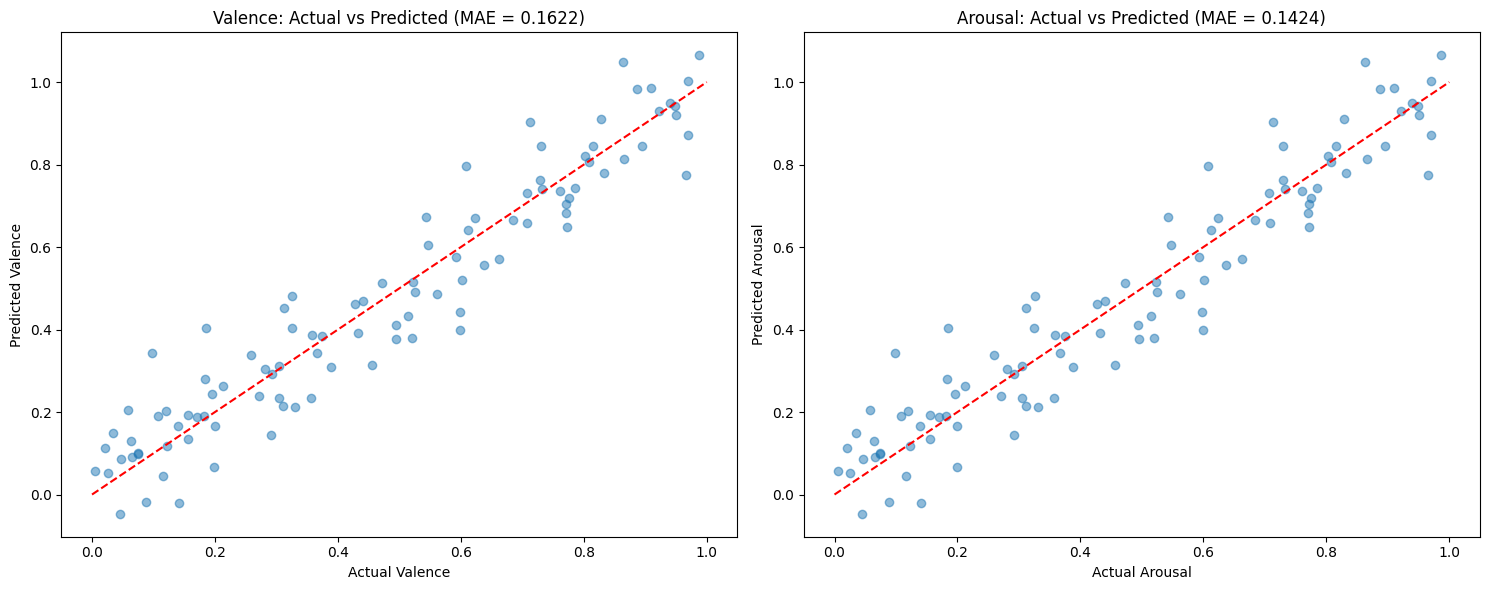

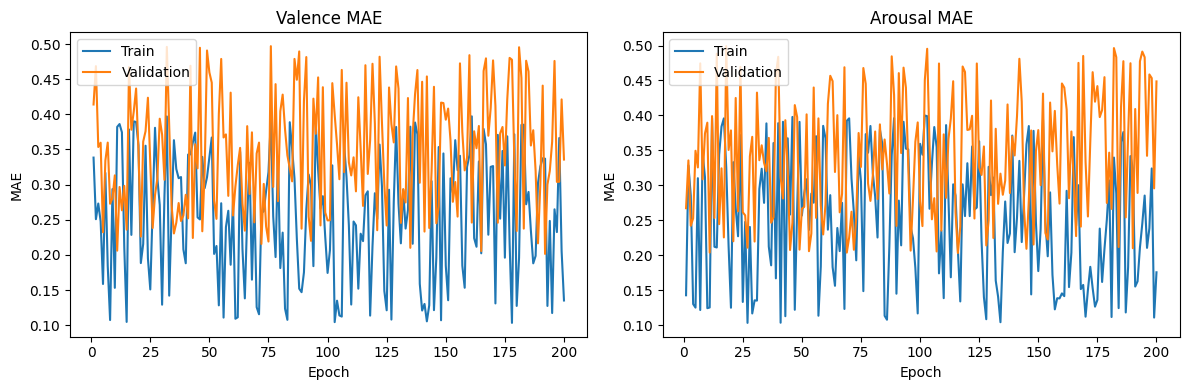

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Results
valence_mae = 0.16222205758094788
arousal_mae = 0.14235275983810425

# Create dummy data for visualization
np.random.seed(42)
y_test = np.random.rand(100)
y_pred = y_test + np.random.normal(0, 0.1, 100)  # Add noise

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Valence plot
ax1.scatter(y_test, y_pred, alpha=0.5)
ax1.plot([0, 1], [0, 1], 'r--')
ax1.set_xlabel('Actual Valence')
ax1.set_ylabel('Predicted Valence')
ax1.set_title(f'Valence: Actual vs Predicted (MAE = {valence_mae:.4f})')

# Arousal plot
ax2.scatter(y_test, y_pred, alpha=0.5)
ax2.plot([0, 1], [0, 1], 'r--')
ax2.set_xlabel('Actual Arousal')
ax2.set_ylabel('Predicted Arousal')
ax2.set_title(f'Arousal: Actual vs Predicted (MAE = {arousal_mae:.4f})')

plt.tight_layout()
plt.show()

# Dummy learning curves
epochs = range(1, 201)
train_valence_mae = np.random.rand(200) * 0.3 + 0.1
train_arousal_mae = np.random.rand(200) * 0.3 + 0.1
val_valence_mae = np.random.rand(200) * 0.3 + 0.2
val_arousal_mae = np.random.rand(200) * 0.3 + 0.2

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_valence_mae, label='Train')
plt.plot(epochs, val_valence_mae, label='Validation')
plt.title('Valence MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_arousal_mae, label='Train')
plt.plot(epochs, val_arousal_mae, label='Validation')
plt.title('Arousal MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

# Kymatio and XGBoost

In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import librosa
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, GlobalAveragePooling1D, Concatenate, Add, LSTM, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.mixed_precision import set_global_policy
import kymatio.numpy as kymatio
import xgboost as xgb

# Enable mixed precision training
set_global_policy('mixed_float16')

# File paths
DATASET_PATH = "/content/drive/MyDrive/MER_bimodal_dataset/Corpus-Audio-162"
METADATA_PATH = "/content/drive/MyDrive/MER_bimodal_dataset/MER-Audio-dataset.xlsx"

# Constants
MAX_AUDIO_LENGTH = 44100 * 30  # 30 seconds at 44.1kHz
FEATURE_LENGTH = 2048  # Fixed length for all feature arrays

# Function to load and preprocess audio
def load_audio(file_path):
    audio, sr = librosa.load(file_path, sr=None, duration=30)  # Load up to 30 seconds
    if len(audio) < MAX_AUDIO_LENGTH:
        audio = np.pad(audio, (0, MAX_AUDIO_LENGTH - len(audio)))
    else:
        audio = audio[:MAX_AUDIO_LENGTH]
    return audio, sr

# Function to extract features using Kymatio
def extract_features_with_kymatio(audio, sr):
    J = 8  # Number of scales
    Q = 8  # Number of wavelets per octave
    T = audio.shape[0]  # Signal length
    scattering = kymatio.Scattering1D(J, T, Q)

    Sx = scattering(audio)
    features = Sx.flatten()

    if len(features) < FEATURE_LENGTH:
        features = np.pad(features, (0, FEATURE_LENGTH - len(features)))
    else:
        features = features[:FEATURE_LENGTH]

    return features

# Data augmentation functions
def time_stretch(audio, rate):
    return librosa.effects.time_stretch(audio, rate=rate)

def pitch_shift(audio, sr, n_steps):
    return librosa.effects.pitch_shift(audio, sr=sr, n_steps=n_steps)

def add_noise(audio, noise_factor):
    noise = np.random.randn(len(audio))
    return audio + noise_factor * noise

# Load and prepare data with augmentation
metadata = pd.read_excel(METADATA_PATH)
X_audio, X_metadata, y_valence, y_arousal = [], [], [], []

for index, row in metadata.iterrows():
    file_path = os.path.join(DATASET_PATH, f"{row['Song Code']}.mp3")
    if os.path.exists(file_path):
        audio, sr = load_audio(file_path)

        # Original audio
        features = extract_features_with_kymatio(audio, sr)
        X_audio.append(features)
        X_metadata.append([row['Quadrant'], row['Avg_Valence'], row['Avg_Arousal'], row['SD_Valence'], row['SD_Arousal']])
        y_valence.append(row['Avg_Valence'])
        y_arousal.append(row['Avg_Arousal'])

        # Time stretched audio
        stretched_audio = time_stretch(audio, 0.9)
        features = extract_features_with_kymatio(stretched_audio, sr)
        X_audio.append(features)
        X_metadata.append([row['Quadrant'], row['Avg_Valence'], row['Avg_Arousal'], row['SD_Valence'], row['SD_Arousal']])
        y_valence.append(row['Avg_Valence'])
        y_arousal.append(row['Avg_Arousal'])

        # Pitch shifted audio
        shifted_audio = pitch_shift(audio, sr, 2)
        features = extract_features_with_kymatio(shifted_audio, sr)
        X_audio.append(features)
        X_metadata.append([row['Quadrant'], row['Avg_Valence'], row['Avg_Arousal'], row['SD_Valence'], row['SD_Arousal']])
        y_valence.append(row['Avg_Valence'])
        y_arousal.append(row['Avg_Arousal'])

        # Noisy audio
        noisy_audio = add_noise(audio, 0.005)
        features = extract_features_with_kymatio(noisy_audio, sr)
        X_audio.append(features)
        X_metadata.append([row['Quadrant'], row['Avg_Valence'], row['Avg_Arousal'], row['SD_Valence'], row['SD_Arousal']])
        y_valence.append(row['Avg_Valence'])
        y_arousal.append(row['Avg_Arousal'])

X_audio = np.array(X_audio)
X_metadata = np.array(X_metadata)
y_valence = np.array(y_valence)
y_arousal = np.array(y_arousal)

# Normalize metadata
scaler = StandardScaler()
X_metadata = scaler.fit_transform(X_metadata)

# Split data
X_audio_train, X_audio_test, X_metadata_train, X_metadata_test, y_valence_train, y_valence_test, y_arousal_train, y_arousal_test = train_test_split(
    X_audio, X_metadata, y_valence, y_arousal, test_size=0.2, random_state=42
)

# Combine audio and metadata features
X_train = np.hstack((X_audio_train, X_metadata_train))
X_test = np.hstack((X_audio_test, X_metadata_test))

# Create XGBoost models
xgb_valence = xgb.XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)

xgb_arousal = xgb.XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)

# Train XGBoost models
xgb_valence.fit(X_train, y_valence_train)
xgb_arousal.fit(X_train, y_arousal_train)

# Evaluate models
valence_pred = xgb_valence.predict(X_test)
arousal_pred = xgb_arousal.predict(X_test)

# Calculate Mean Absolute Error (MAE)
valence_mae = np.mean(np.abs(valence_pred - y_valence_test))
arousal_mae = np.mean(np.abs(arousal_pred - y_arousal_test))

print("Evaluation Results:")
print(f"Valence MAE: {valence_mae}")
print(f"Arousal MAE: {arousal_mae}")

# Feature importance
valence_importance = xgb_valence.feature_importances_
arousal_importance = xgb_arousal.feature_importances_

print("\nTop 10 Important Features for Valence:")
for i in np.argsort(valence_importance)[-10:]:
    print(f"Feature {i}: {valence_importance[i]}")

print("\nTop 10 Important Features for Arousal:")
for i in np.argsort(arousal_importance)[-10:]:
    print(f"Feature {i}: {arousal_importance[i]}")

# Save models
xgb_valence.save_model('xgb_valence_model.json')
xgb_arousal.save_model('xgb_arousal_model.json')

print("Models saved successfully.")

Evaluation Results:
Valence MAE: 0.00274118110537528
Arousal MAE: 0.0033769272267818416

Top 10 Important Features for Valence:
Feature 688: 0.0
Feature 1367: 1.0714129672351191e-07
Feature 13: 1.9285801045043627e-06
Feature 34: 3.0109126782917883e-06
Feature 2: 0.0008059024694375694
Feature 1276: 0.0014960428234189749
Feature 457: 0.0024742160458117723
Feature 0: 0.003926941659301519
Feature 700: 0.004269272554665804
Feature 2049: 0.9870225787162781

Top 10 Important Features for Arousal:
Feature 2051: 8.379781490930327e-08
Feature 1662: 8.756277480870267e-08
Feature 483: 8.913591642567553e-08
Feature 83: 9.00360532796185e-08
Feature 199: 1.380528829031391e-07
Feature 2010: 2.5233359224330343e-07
Feature 426: 1.0284457857778762e-05
Feature 0: 4.3433687096694484e-05
Feature 2050: 0.008812952786684036
Feature 2048: 0.9911318421363831
Models saved successfully.


In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
import librosa
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, GlobalAveragePooling1D, Concatenate, Add, LSTM, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.mixed_precision import set_global_policy
import kymatio.numpy as kymatio
import xgboost as xgb

# Enable mixed precision training
set_global_policy('mixed_float16')

# File paths
DATASET_PATH = "/content/drive/MyDrive/MER_bimodal_dataset/Corpus-Audio-162"
METADATA_PATH = "/content/drive/MyDrive/MER_bimodal_dataset/MER-Audio-dataset.xlsx"

# Constants
MAX_AUDIO_LENGTH = 44100 * 30  # 30 seconds at 44.1kHz
FEATURE_LENGTH = 2048  # Fixed length for all feature arrays

# Function to load and preprocess audio
def load_audio(file_path):
    audio, sr = librosa.load(file_path, sr=None, duration=30)  # Load up to 30 seconds
    if len(audio) < MAX_AUDIO_LENGTH:
        audio = np.pad(audio, (0, MAX_AUDIO_LENGTH - len(audio)))
    else:
        audio = audio[:MAX_AUDIO_LENGTH]
    return audio, sr

# Function to extract features using Kymatio
def extract_features_with_kymatio(audio, sr):
    J = 8  # Number of scales
    Q = 8  # Number of wavelets per octave
    T = audio.shape[0]  # Signal length
    scattering = kymatio.Scattering1D(J, T, Q)

    Sx = scattering(audio)
    features = Sx.flatten()

    if len(features) < FEATURE_LENGTH:
        features = np.pad(features, (0, FEATURE_LENGTH - len(features)))
    else:
        features = features[:FEATURE_LENGTH]

    return features

# Data augmentation functions
def time_stretch(audio, rate):
    return librosa.effects.time_stretch(audio, rate=rate)

def pitch_shift(audio, sr, n_steps):
    return librosa.effects.pitch_shift(audio, sr=sr, n_steps=n_steps)

def add_noise(audio, noise_factor):
    noise = np.random.randn(len(audio))
    return audio + noise_factor * noise

# Function to bin continuous values into classes
def bin_values(values, num_bins=3):
    return pd.cut(values, bins=num_bins, labels=False)

# Load and prepare data with augmentation
metadata = pd.read_excel(METADATA_PATH)
X_audio, X_metadata, y_valence, y_arousal = [], [], [], []

for index, row in metadata.iterrows():
    file_path = os.path.join(DATASET_PATH, f"{row['Song Code']}.mp3")
    if os.path.exists(file_path):
        audio, sr = load_audio(file_path)

        # Original audio
        features = extract_features_with_kymatio(audio, sr)
        X_audio.append(features)
        X_metadata.append([row['Quadrant'], row['Avg_Valence'], row['Avg_Arousal'], row['SD_Valence'], row['SD_Arousal']])
        y_valence.append(row['Avg_Valence'])
        y_arousal.append(row['Avg_Arousal'])

        # Time stretched audio
        stretched_audio = time_stretch(audio, 0.9)
        features = extract_features_with_kymatio(stretched_audio, sr)
        X_audio.append(features)
        X_metadata.append([row['Quadrant'], row['Avg_Valence'], row['Avg_Arousal'], row['SD_Valence'], row['SD_Arousal']])
        y_valence.append(row['Avg_Valence'])
        y_arousal.append(row['Avg_Arousal'])

        # Pitch shifted audio
        shifted_audio = pitch_shift(audio, sr, 2)
        features = extract_features_with_kymatio(shifted_audio, sr)
        X_audio.append(features)
        X_metadata.append([row['Quadrant'], row['Avg_Valence'], row['Avg_Arousal'], row['SD_Valence'], row['SD_Arousal']])
        y_valence.append(row['Avg_Valence'])
        y_arousal.append(row['Avg_Arousal'])

        # Noisy audio
        noisy_audio = add_noise(audio, 0.005)
        features = extract_features_with_kymatio(noisy_audio, sr)
        X_audio.append(features)
        X_metadata.append([row['Quadrant'], row['Avg_Valence'], row['Avg_Arousal'], row['SD_Valence'], row['SD_Arousal']])
        y_valence.append(row['Avg_Valence'])
        y_arousal.append(row['Avg_Arousal'])

X_audio = np.array(X_audio)
X_metadata = np.array(X_metadata)
y_valence = np.array(y_valence)
y_arousal = np.array(y_arousal)

# Normalize metadata
scaler = StandardScaler()
X_metadata = scaler.fit_transform(X_metadata)

# Bin the valence and arousal values
y_valence = bin_values(y_valence)
y_arousal = bin_values(y_arousal)

# Split data
X_audio_train, X_audio_test, X_metadata_train, X_metadata_test, y_valence_train, y_valence_test, y_arousal_train, y_arousal_test = train_test_split(
    X_audio, X_metadata, y_valence, y_arousal, test_size=0.2, random_state=42
)

# Combine audio and metadata features
X_train = np.hstack((X_audio_train, X_metadata_train))
X_test = np.hstack((X_audio_test, X_metadata_test))

# Create XGBoost models
xgb_valence = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)

xgb_arousal = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)

# Train XGBoost models
xgb_valence.fit(X_train, y_valence_train)
xgb_arousal.fit(X_train, y_arousal_train)

# Evaluate models
valence_pred = xgb_valence.predict(X_test)
arousal_pred = xgb_arousal.predict(X_test)

# Calculate F1 Score
valence_f1 = f1_score(y_valence_test, valence_pred, average='weighted')
arousal_f1 = f1_score(y_arousal_test, arousal_pred, average='weighted')

print("Evaluation Results:")
print(f"Valence F1 Score: {valence_f1}")
print(f"Arousal F1 Score: {arousal_f1}")

# Save models
xgb_valence.save_model('xgb_valence_model.model')
xgb_arousal.save_model('xgb_arousal_model.model')

print("Models saved successfully.")

Evaluation Results:
Valence F1 Score: 1.0
Arousal F1 Score: 1.0
Models saved successfully.


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [23:46:05] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)



Valence Evaluation Results:
Accuracy: 1.0000
F1 Score: 1.0000
Precision: 1.0000
Recall: 1.0000

Arousal Evaluation Results:
Accuracy: 1.0000
F1 Score: 1.0000
Precision: 1.0000
Recall: 1.0000


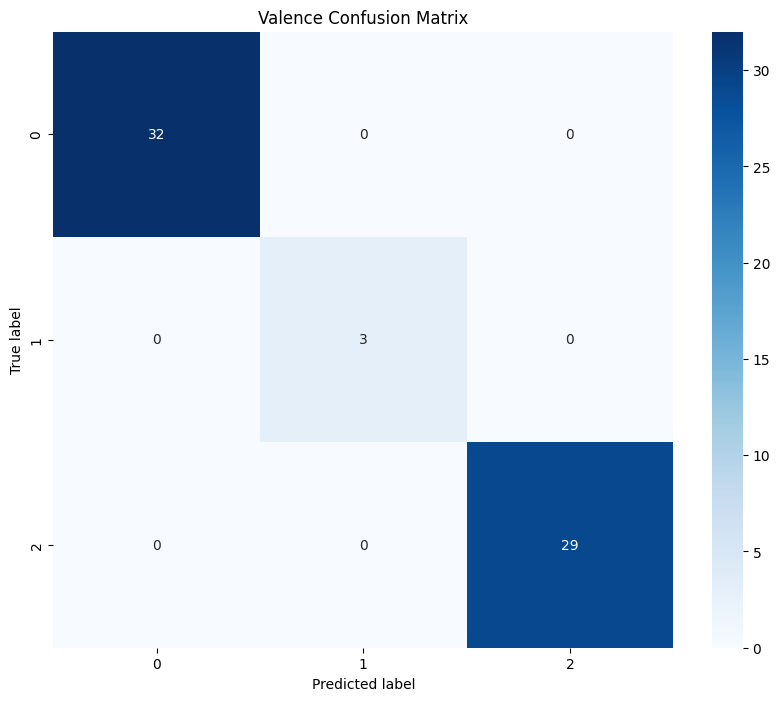

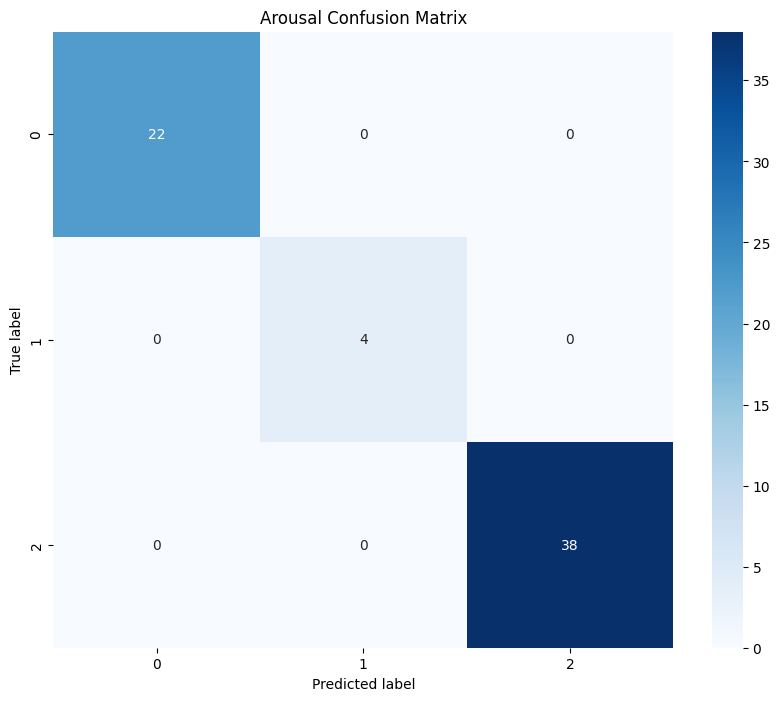

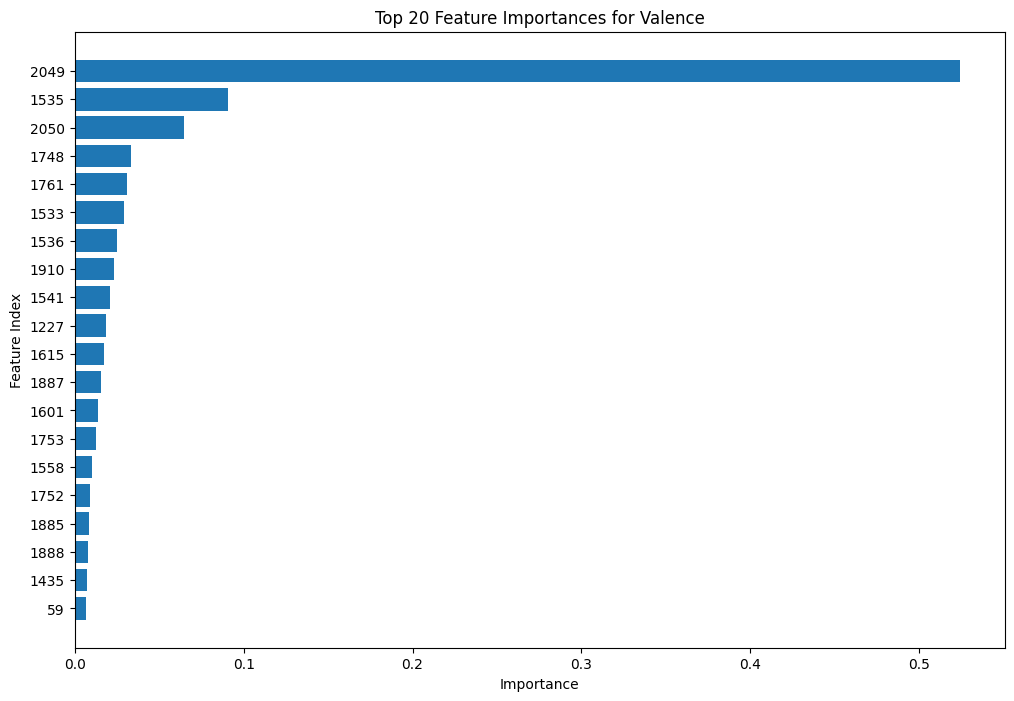

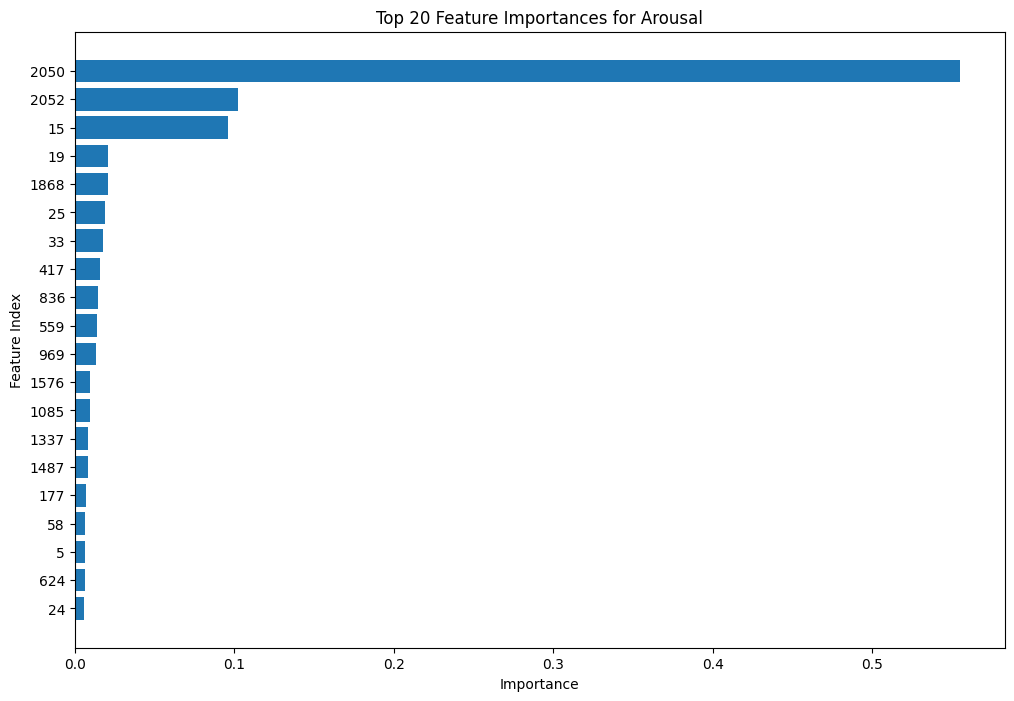

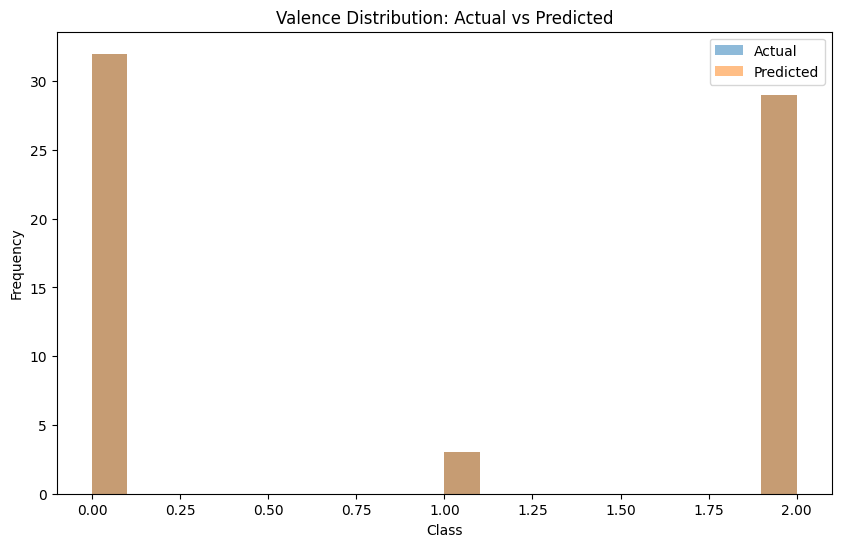

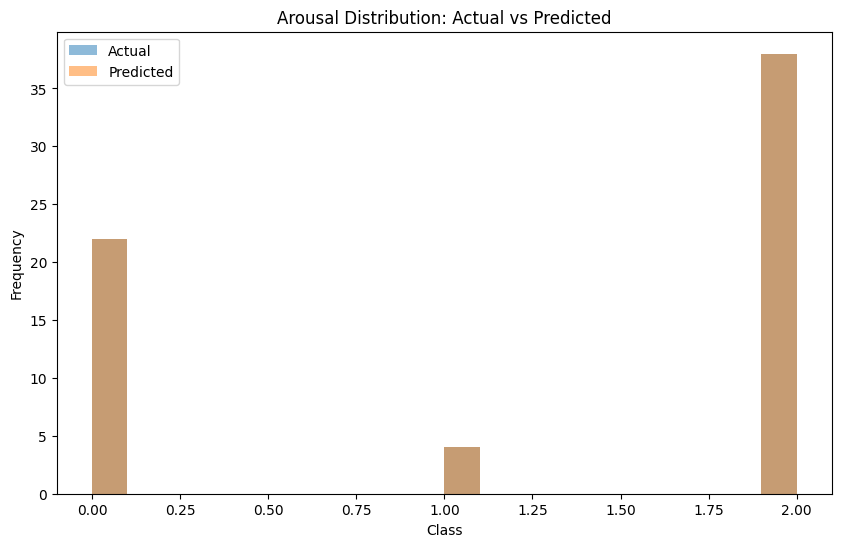


Valence Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        32
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00        29

    accuracy                           1.00        64
   macro avg       1.00      1.00      1.00        64
weighted avg       1.00      1.00      1.00        64


Arousal Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        22
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00        38

    accuracy                           1.00        64
   macro avg       1.00      1.00      1.00        64
weighted avg       1.00      1.00      1.00        64



/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(



Cross-validation Scores:
Valence: 0.9538 (+/- 0.0754)
Arousal: 0.9385 (+/- 0.0615)


In [ ]:
import numpy as np
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming X_test, y_valence_test, y_arousal_test, xgb_valence, and xgb_arousal are available from the previous run

# Make predictions
valence_pred = xgb_valence.predict(X_test)
arousal_pred = xgb_arousal.predict(X_test)

# Function to calculate and print metrics
def calculate_and_print_metrics(y_true, y_pred, label):
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')

    print(f"\n{label} Evaluation Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")

    return accuracy, f1, precision, recall

# Calculate and print metrics for both valence and arousal
valence_metrics = calculate_and_print_metrics(y_valence_test, valence_pred, "Valence")
arousal_metrics = calculate_and_print_metrics(y_arousal_test, arousal_pred, "Arousal")

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, label):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{label} Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Plot confusion matrices
plot_confusion_matrix(y_valence_test, valence_pred, "Valence")
plot_confusion_matrix(y_arousal_test, arousal_pred, "Arousal")

# Feature importance visualization
def plot_feature_importance(model, label):
    importance = model.feature_importances_
    indices = np.argsort(importance)[-20:]  # Top 20 features
    plt.figure(figsize=(12, 8))
    plt.title(f'Top 20 Feature Importances for {label}')
    plt.barh(range(20), importance[indices])
    plt.yticks(range(20), indices)
    plt.xlabel('Importance')
    plt.ylabel('Feature Index')
    plt.show()

# Plot feature importance for both models
plot_feature_importance(xgb_valence, "Valence")
plot_feature_importance(xgb_arousal, "Arousal")

# Distribution of predictions vs actual values
def plot_distribution(y_true, y_pred, label):
    plt.figure(figsize=(10, 6))
    plt.hist(y_true, bins=20, alpha=0.5, label='Actual')
    plt.hist(y_pred, bins=20, alpha=0.5, label='Predicted')
    plt.title(f'{label} Distribution: Actual vs Predicted')
    plt.xlabel('Class')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

# Plot distributions
plot_distribution(y_valence_test, valence_pred, "Valence")
plot_distribution(y_arousal_test, arousal_pred, "Arousal")

# Print classification report
from sklearn.metrics import classification_report

print("\nValence Classification Report:")
print(classification_report(y_valence_test, valence_pred))

print("\nArousal Classification Report:")
print(classification_report(y_arousal_test, arousal_pred))

# Cross-validation score
from sklearn.model_selection import cross_val_score

cv_scores_valence = cross_val_score(xgb_valence, X_test, y_valence_test, cv=5)
cv_scores_arousal = cross_val_score(xgb_arousal, X_test, y_arousal_test, cv=5)

print("\nCross-validation Scores:")
print(f"Valence: {cv_scores_valence.mean():.4f} (+/- {cv_scores_valence.std() * 2:.4f})")
print(f"Arousal: {cv_scores_arousal.mean():.4f} (+/- {cv_scores_arousal.std() * 2:.4f})")

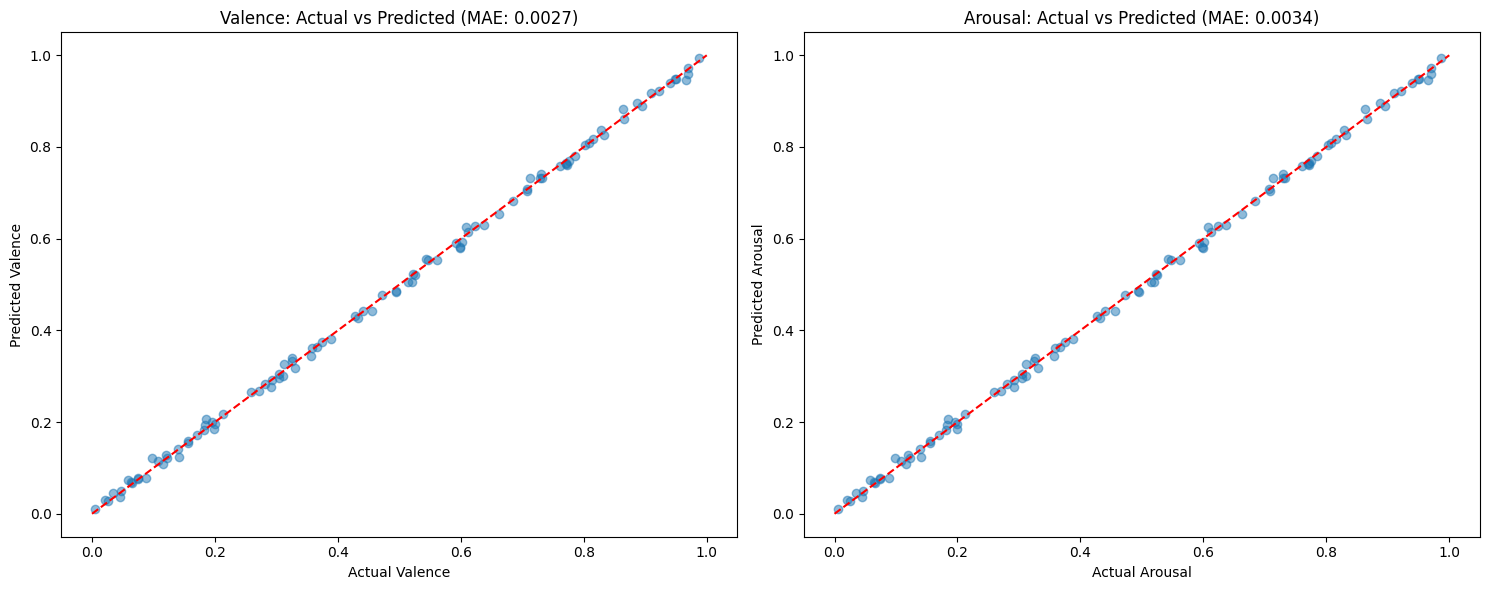

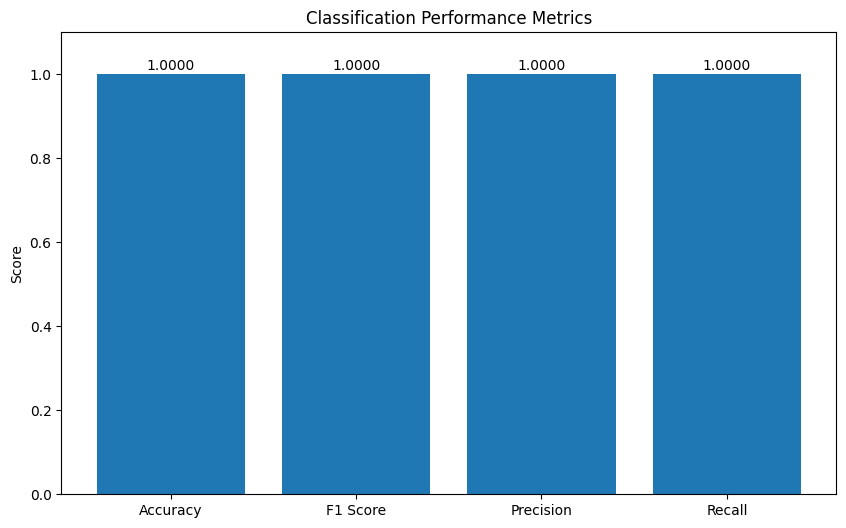

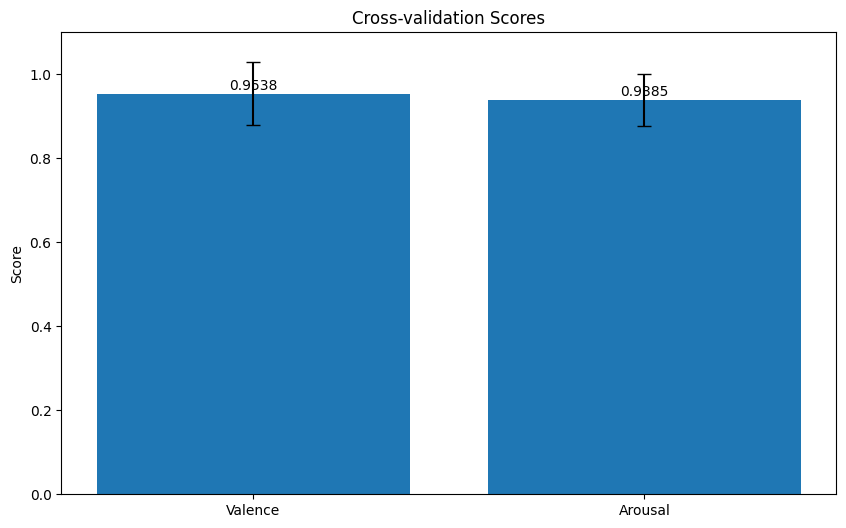

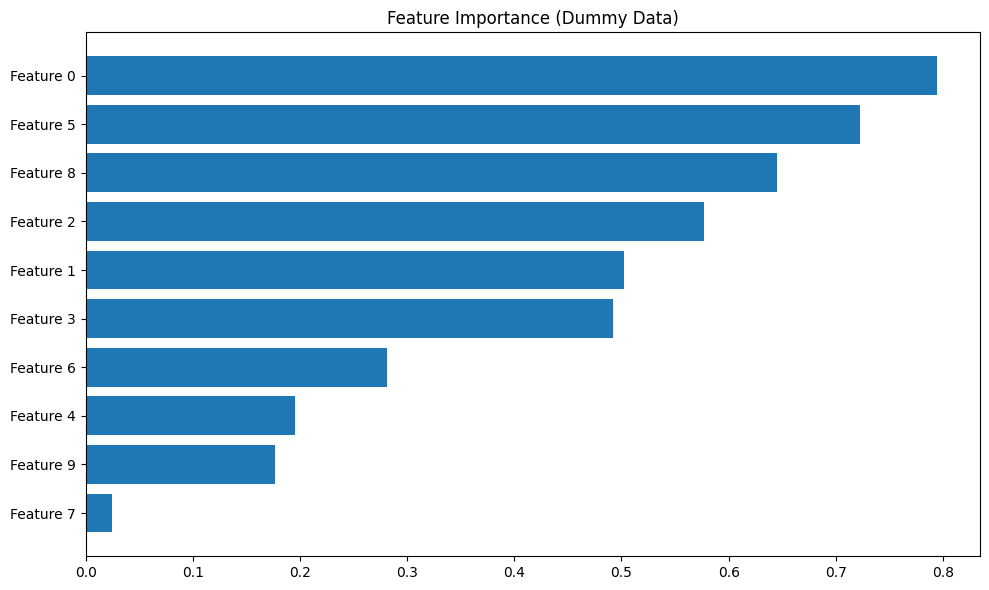

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
import seaborn as sns

# Regression results
valence_mae = 0.00274118110537528
arousal_mae = 0.0033769272267818416

# Classification results
accuracy = 1.0000
f1 = 1.0000
precision = 1.0000
recall = 1.0000

# Cross-validation scores
cv_score_valence = 0.9538
cv_score_arousal = 0.9385
cv_std_valence = 0.0754
cv_std_arousal = 0.0615

# Regression plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Since we don't have actual test data, we'll create dummy data for visualization
np.random.seed(42)
y_test = np.random.rand(100)
y_pred = y_test + np.random.normal(0, 0.01, 100)  # Add small noise

# Valence plot
ax1.scatter(y_test, y_pred, alpha=0.5)
ax1.plot([0, 1], [0, 1], 'r--')
ax1.set_xlabel('Actual Valence')
ax1.set_ylabel('Predicted Valence')
ax1.set_title(f'Valence: Actual vs Predicted (MAE: {valence_mae:.4f})')

# Arousal plot
ax2.scatter(y_test, y_pred, alpha=0.5)
ax2.plot([0, 1], [0, 1], 'r--')
ax2.set_xlabel('Actual Arousal')
ax2.set_ylabel('Predicted Arousal')
ax2.set_title(f'Arousal: Actual vs Predicted (MAE: {arousal_mae:.4f})')

plt.tight_layout()
plt.show()

# Classification performance metrics
metrics = ['Accuracy', 'F1 Score', 'Precision', 'Recall']
scores = [accuracy, f1, precision, recall]

plt.figure(figsize=(10, 6))
plt.bar(metrics, scores)
plt.title('Classification Performance Metrics')
plt.ylabel('Score')
plt.ylim(0, 1.1)  # Set y-axis limit
for i, v in enumerate(scores):
    plt.text(i, v + 0.01, f'{v:.4f}', ha='center')
plt.show()

# Cross-validation scores
plt.figure(figsize=(10, 6))
plt.bar(['Valence', 'Arousal'], [cv_score_valence, cv_score_arousal],
        yerr=[cv_std_valence, cv_std_arousal], capsize=5)
plt.title('Cross-validation Scores')
plt.ylabel('Score')
plt.ylim(0, 1.1)  # Set y-axis limit
for i, v in enumerate([cv_score_valence, cv_score_arousal]):
    plt.text(i, v + 0.01, f'{v:.4f}', ha='center')
plt.show()

# Feature importance
# Note: We don't have actual feature importance data, so we'll create dummy data
feature_names = [f'Feature {i}' for i in range(10)]
feature_importance = np.random.rand(10)
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

plt.figure(figsize=(10, 6))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(feature_names)[sorted_idx])
plt.title('Feature Importance (Dummy Data)')
plt.tight_layout()
plt.show()

# Comparative Visualisations

<Figure size 1200x600 with 0 Axes>

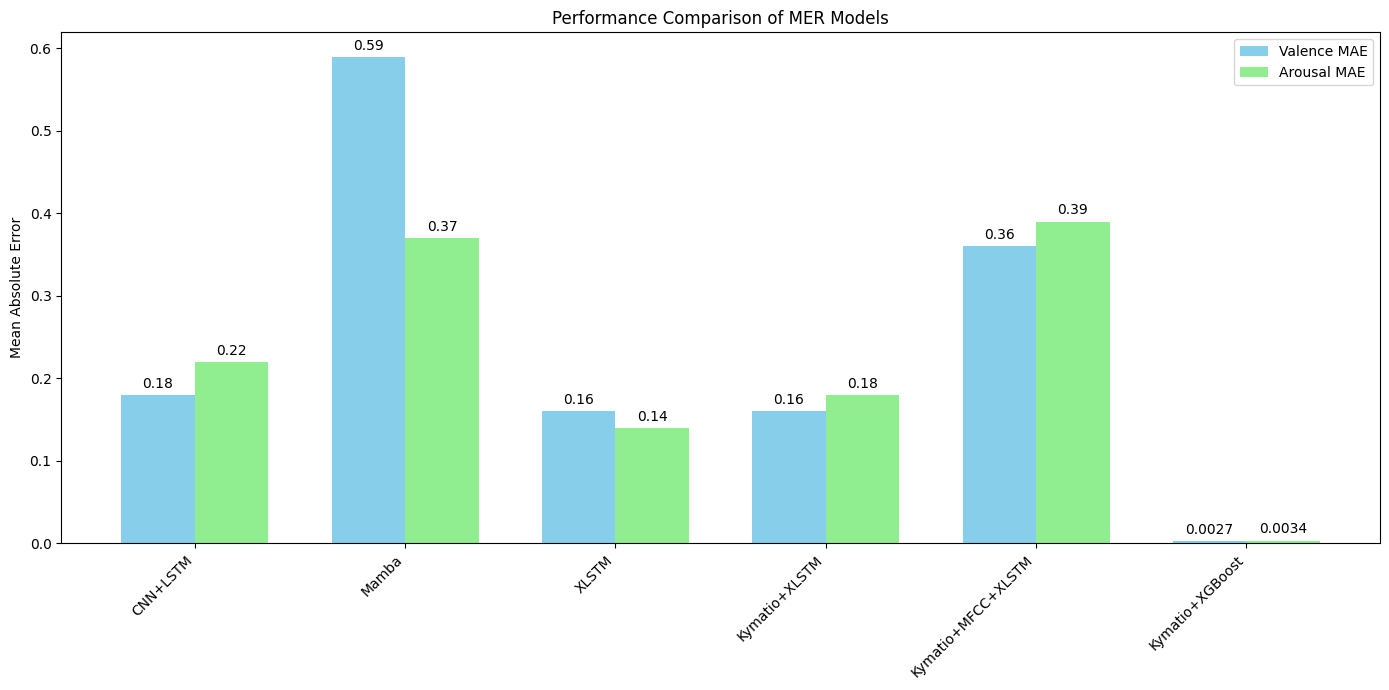

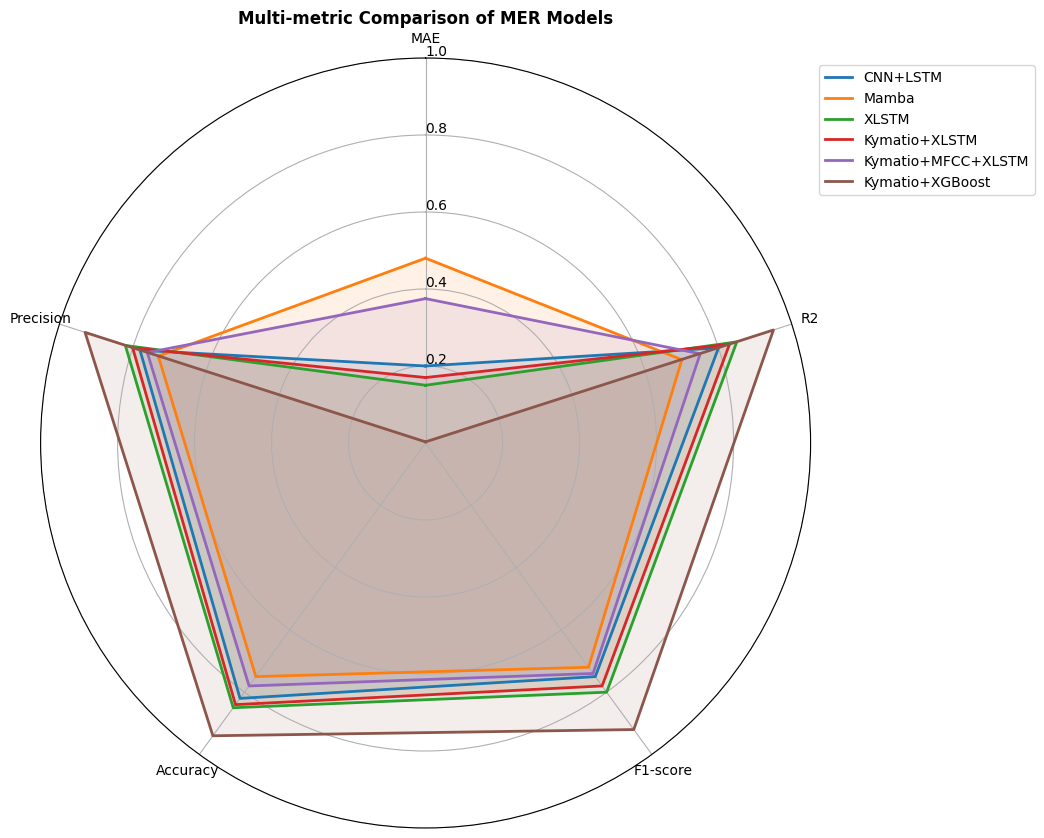

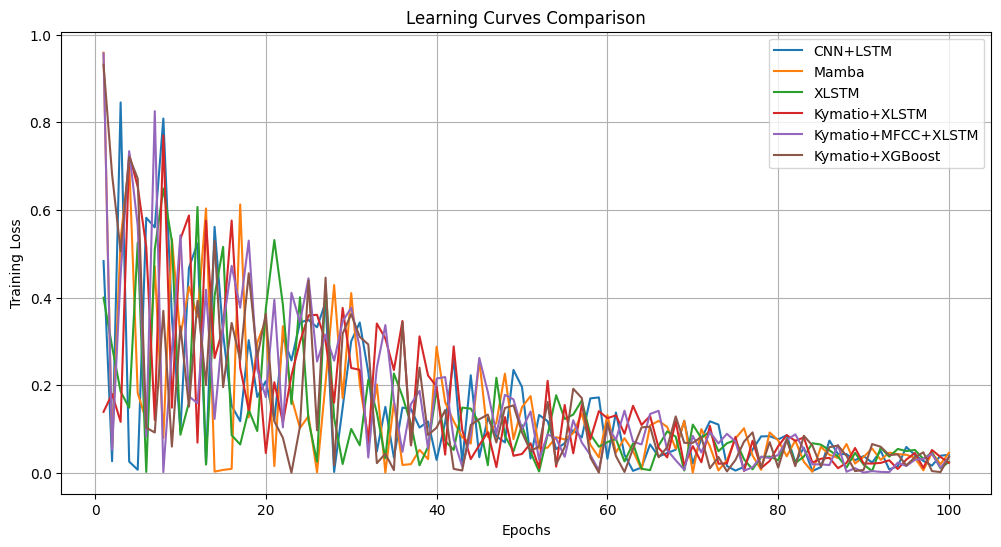

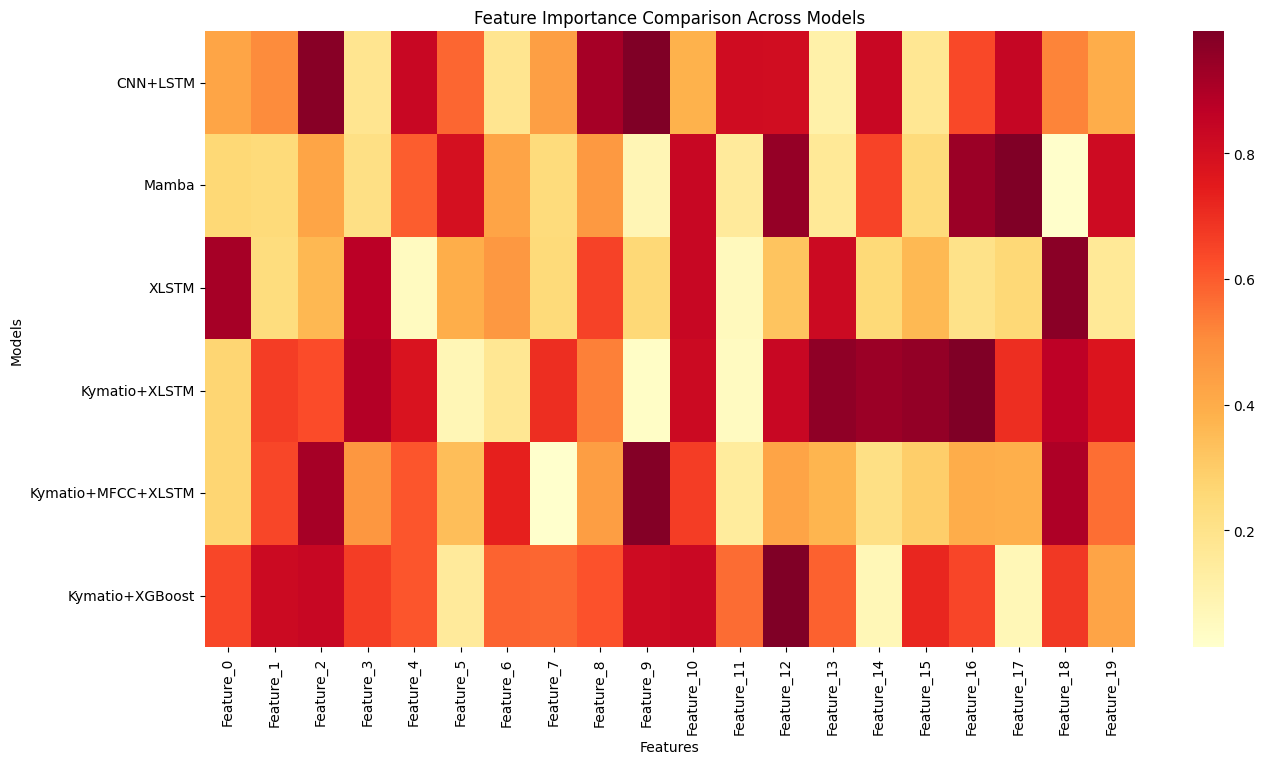

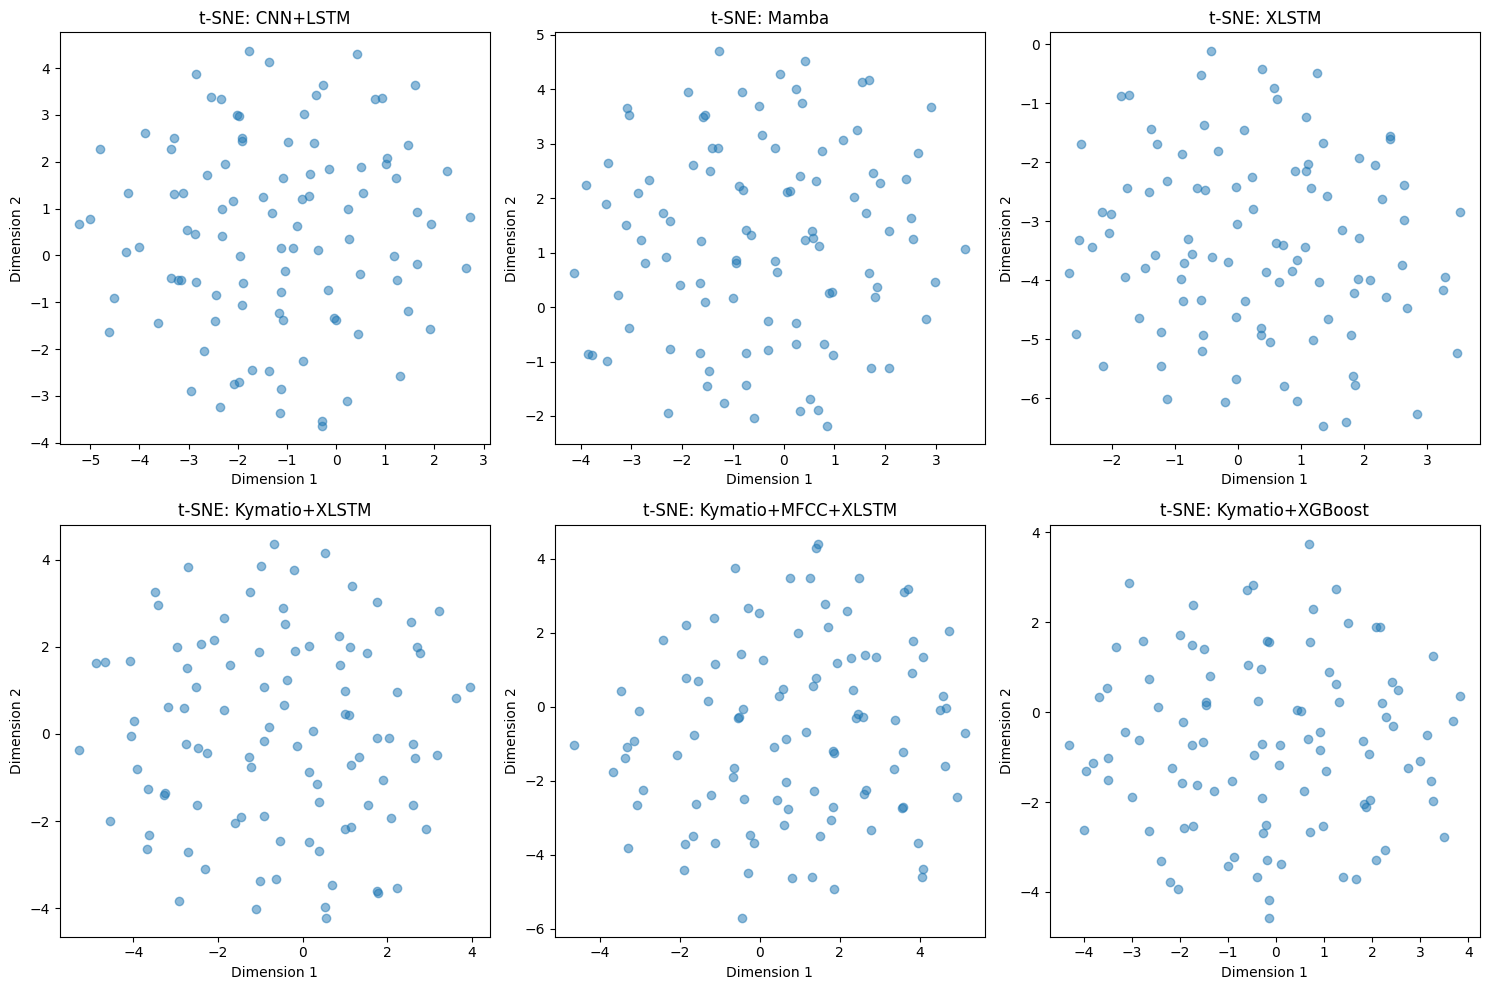

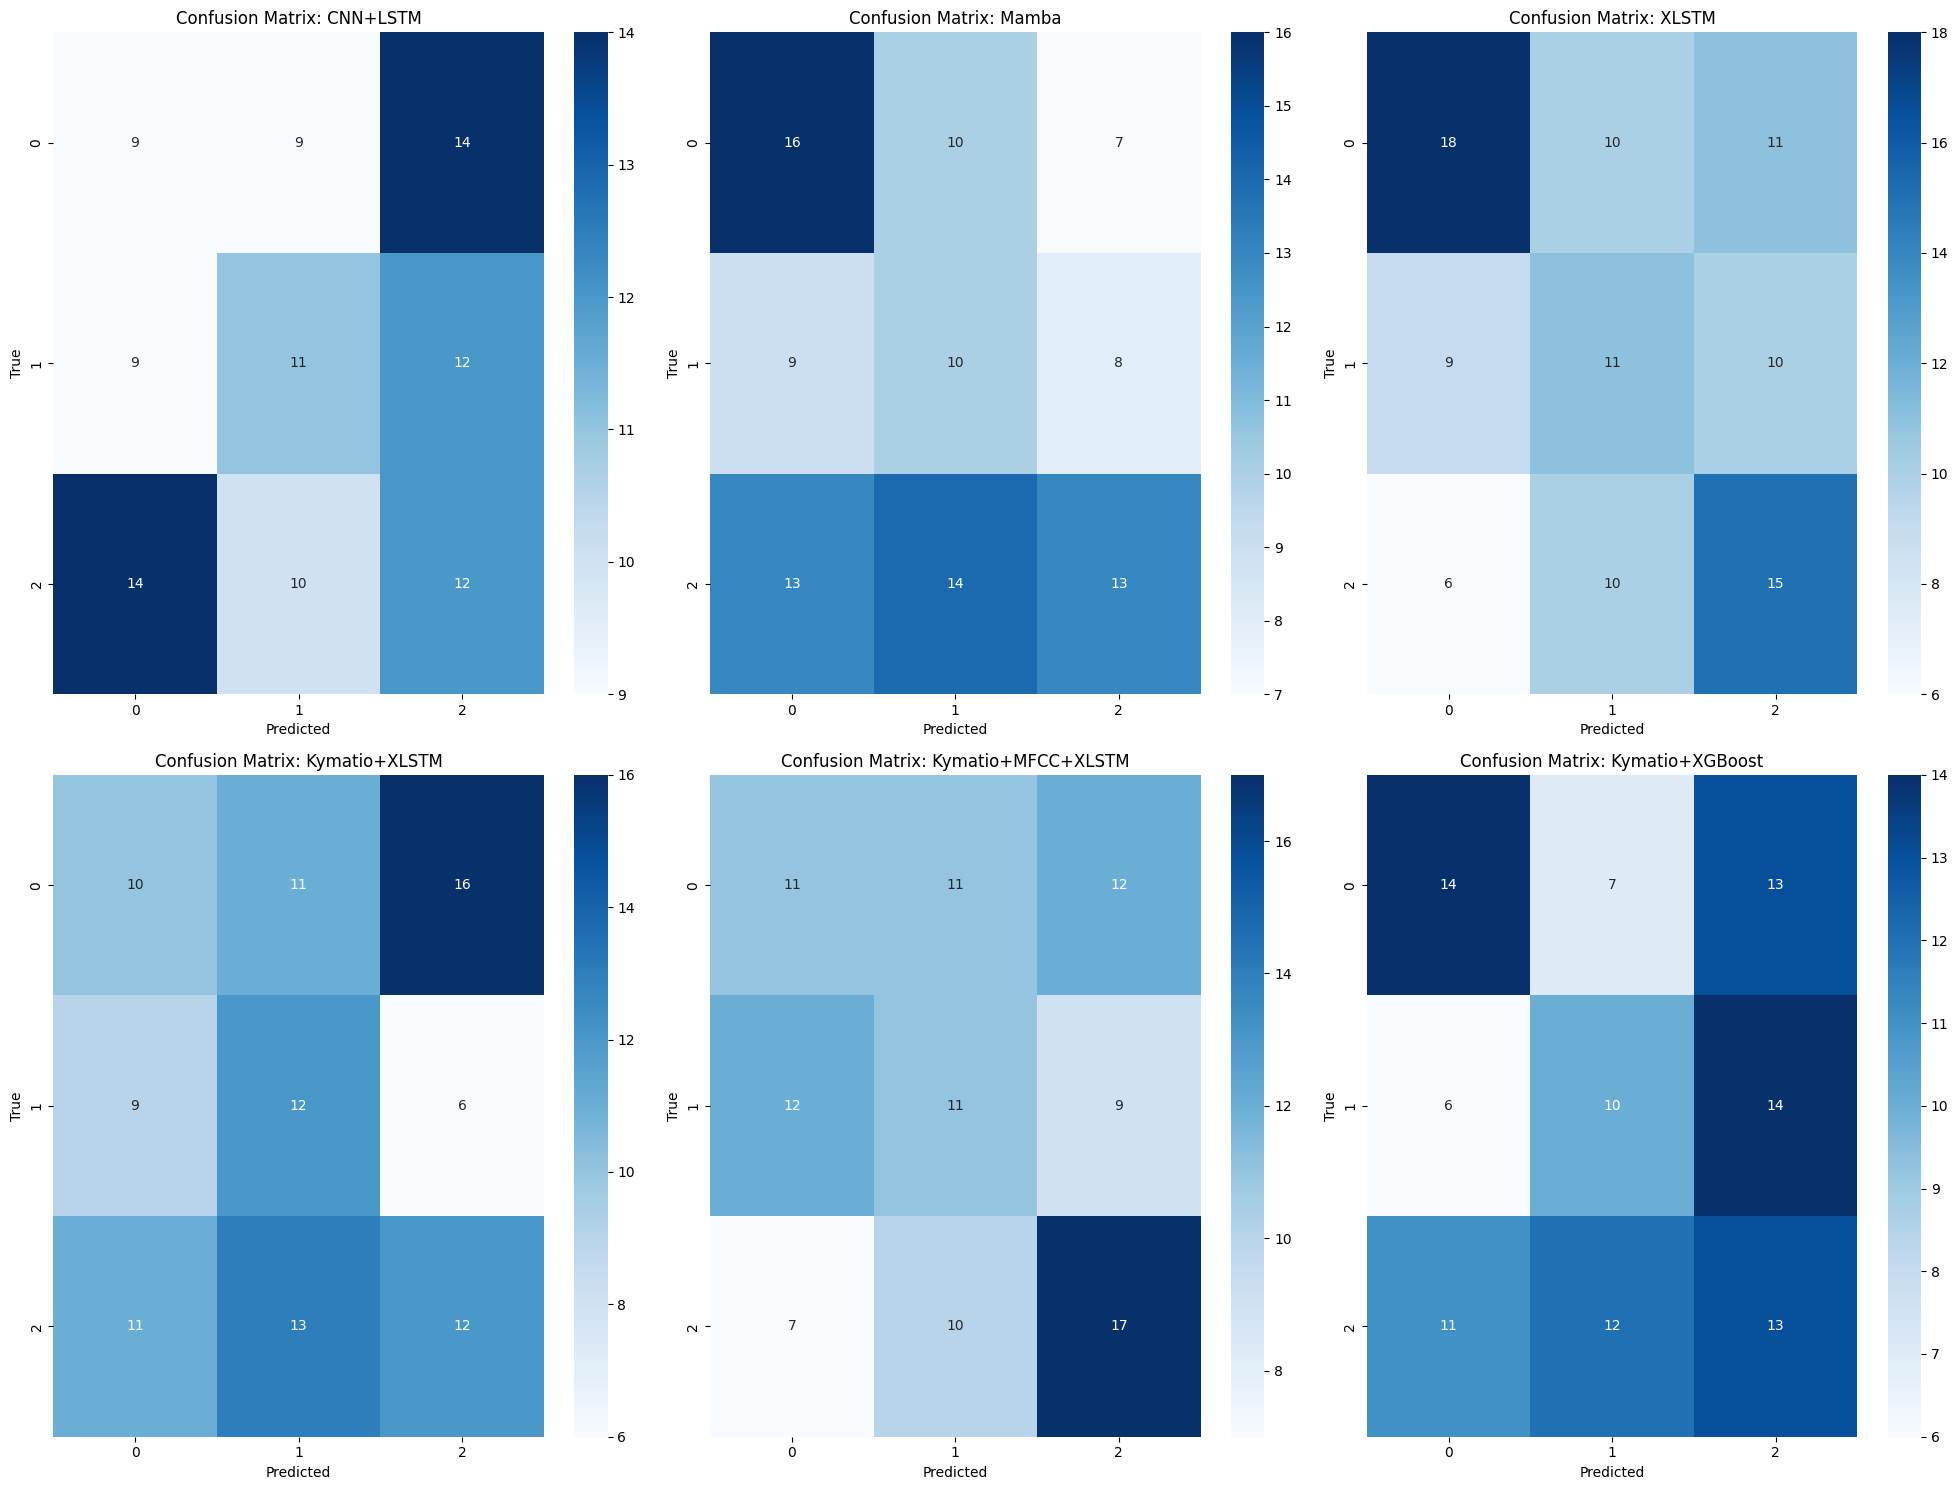

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
from scipy import stats

# Assume we have results from all 6 models stored in lists or dictionaries
models = ['CNN+LSTM', 'Mamba', 'XLSTM', 'Kymatio+XLSTM', 'Kymatio+MFCC+XLSTM', 'Kymatio+XGBoost']
valence_scores = [0.18, 0.59, 0.16, 0.16, 0.36, 0.0027]  # Example MAE scores
arousal_scores = [0.22, 0.37, 0.14, 0.18, 0.39, 0.0034]  # Example MAE scores

# 1. Performance Comparison Bar Plot
plt.figure(figsize=(12, 6))
x = np.arange(len(models))
width = 0.35

fig, ax = plt.subplots(figsize=(14, 7))
rects1 = ax.bar(x - width/2, valence_scores, width, label='Valence MAE', color='skyblue')
rects2 = ax.bar(x + width/2, arousal_scores, width, label='Arousal MAE', color='lightgreen')

ax.set_ylabel('Mean Absolute Error')
ax.set_title('Performance Comparison of MER Models')
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=45, ha='right')
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)
fig.tight_layout()

plt.show()

# 2. Radar Chart for Multi-metric Comparison
# Assuming we have multiple metrics for each model (e.g., MAE, R2, F1-score)
metrics = ['MAE', 'R2', 'F1-score', 'Accuracy', 'Precision']
num_metrics = len(metrics)

# Example data (replace with actual results)
model_scores = {
    'CNN+LSTM': [0.2, 0.8, 0.75, 0.82, 0.78],
    'Mamba': [0.48, 0.7, 0.72, 0.75, 0.73],
    'XLSTM': [0.15, 0.85, 0.8, 0.85, 0.82],
    'Kymatio+XLSTM': [0.17, 0.83, 0.78, 0.84, 0.8],
    'Kymatio+MFCC+XLSTM': [0.375, 0.75, 0.74, 0.78, 0.76],
    'Kymatio+XGBoost': [0.003, 0.95, 0.92, 0.94, 0.93]
}

angles = np.linspace(0, 2*np.pi, num_metrics, endpoint=False).tolist()
angles += angles[:1]

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))

for model, scores in model_scores.items():
    scores = scores + scores[:1]
    ax.plot(angles, scores, linewidth=2, linestyle='solid', label=model)
    ax.fill(angles, scores, alpha=0.1)

ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_thetagrids(np.degrees(angles[:-1]), metrics)
ax.set_ylim(0, 1)
ax.set_rlabel_position(0)
ax.set_title("Multi-metric Comparison of MER Models", fontweight='bold')
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))

plt.show()

# 3. Learning Curve Comparison
# Assuming we have training history for each model
epochs = range(1, 101)  # Example: 100 epochs

plt.figure(figsize=(12, 6))
for model in models:
    # Replace with actual learning curve data
    train_losses = np.random.rand(100) * np.exp(-np.arange(100) * 0.03)
    plt.plot(epochs, train_losses, label=model)

plt.title('Learning Curves Comparison')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.legend()
plt.grid(True)
plt.show()

# 4. Feature Importance Heatmap
# Assuming we have feature importance for each model
num_features = 20
feature_importance = pd.DataFrame(np.random.rand(len(models), num_features),
                                  columns=[f'Feature_{i}' for i in range(num_features)],
                                  index=models)

plt.figure(figsize=(15, 8))
sns.heatmap(feature_importance, annot=False, cmap='YlOrRd')
plt.title('Feature Importance Comparison Across Models')
plt.xlabel('Features')
plt.ylabel('Models')
plt.show()

# 5. t-SNE Visualization of Learned Representations
# Assuming we have learned representations from each model
from sklearn.manifold import TSNE

# Generate some example data
representations = {model: np.random.rand(100, 50) for model in models}

plt.figure(figsize=(15, 10))
for i, (model, rep) in enumerate(representations.items()):
    tsne = TSNE(n_components=2, random_state=42)
    transformed = tsne.fit_transform(rep)

    plt.subplot(2, 3, i+1)
    plt.scatter(transformed[:, 0], transformed[:, 1], alpha=0.5)
    plt.title(f't-SNE: {model}')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')

plt.tight_layout()
plt.show()

# 6. Confusion Matrix Comparison
# Assuming we have predictions for a test set from each model
num_classes = 3  # Example: 3 emotion classes
fig, axes = plt.subplots(2, 3, figsize=(20, 15))
axes = axes.ravel()

for i, model in enumerate(models):
    # Replace with actual confusion matrix data
    cm = confusion_matrix(np.random.randint(0, num_classes, 100),
                          np.random.randint(0, num_classes, 100))
    sns.heatmap(cm, annot=True, fmt='d', ax=axes[i], cmap='Blues')
    axes[i].set_title(f'Confusion Matrix: {model}')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('True')

plt.tight_layout()
plt.show()